# Streamflow Modelling Using Machine Learning Based on Discharge and Precipitation Time series (Case Study: Santa Coloma de Gramenet Hydrometric Station)

In [6]:
plt.rcParams['figure.figsize'] = (20, 10)

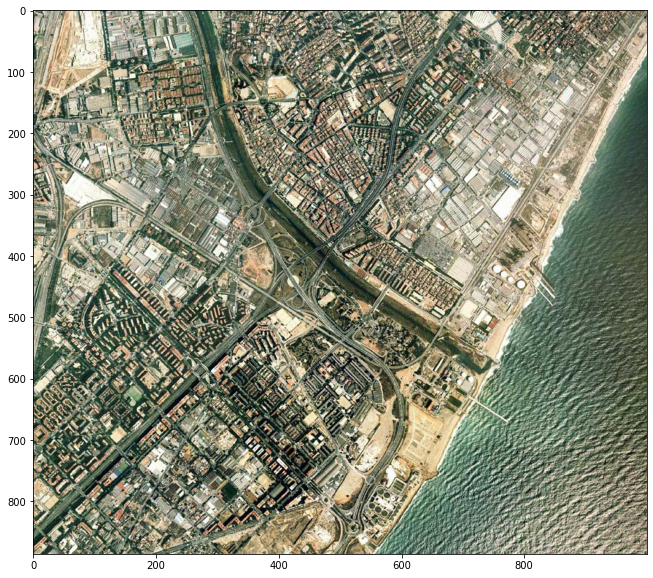

In [9]:
import matplotlib.pyplot as plt
image1 = plt.imread("../input/bess-river/figu002.jpg")
plt.imshow(image1)

The objective of this work is to model the streamflow discharge at the outlet of the Besós river basin

The data schema is:

- fecha: daily data
- Gramenet: daily discharge at the "Santa Coloma de Gramenet" gauging station. Units are in m3/s
- Barcelona, Barcelona_fabra and Sabadell_aero: daily rainfall in the "Barcelona", "Barcelona Fabra" and "Sabadell Aeropuerto" rain stations. Units are in mm
- Garriga,	Castellar,	Llica,	el_Mogent,	Mogoda: daily upstream flow discharge at the "La Garriga", "Castellar Valles", "Lliça de Vall", "Montornes Valles", "Santa Perpetua de Mogoda" gauging stations. Units are in m3/s

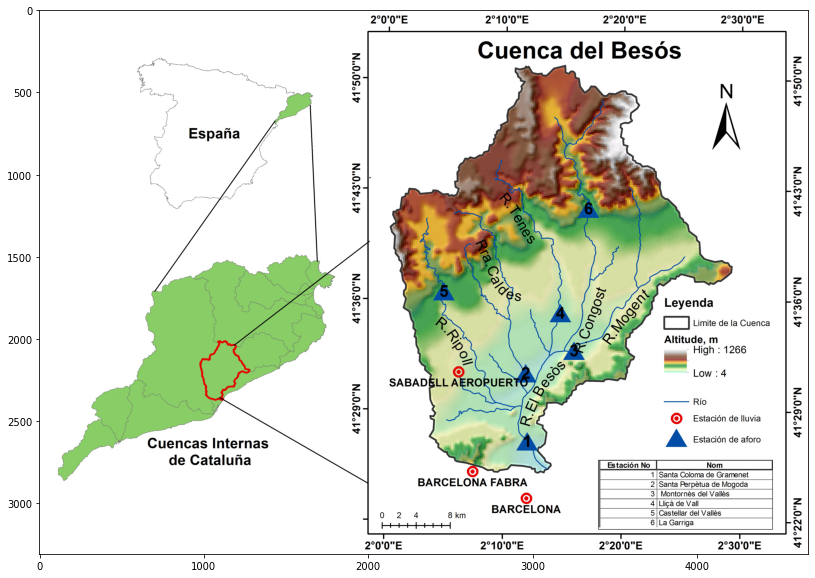

In [10]:
import matplotlib.pyplot as plt
image2 = plt.imread("../input/location-map-of-the-bess-river-basin/besos.jpg")
plt.imshow(image2)

#### Objetive

This project consists of using data from the rain stations ("Barcelona", "Barcelona Fabra" and "Sabadell Aeropuerto"), the upstream gauging stations ("La Garriga", "Castellar Valles", "Lliça de Vall "," Montornes Valles "," Santa Perpetua de Mogoda ") and the historical flow data in the" Santa Coloma de Gramenet "gauging station, to model the flow values in the latter gauging station

For this, the CRISP-DM methodology will be used.

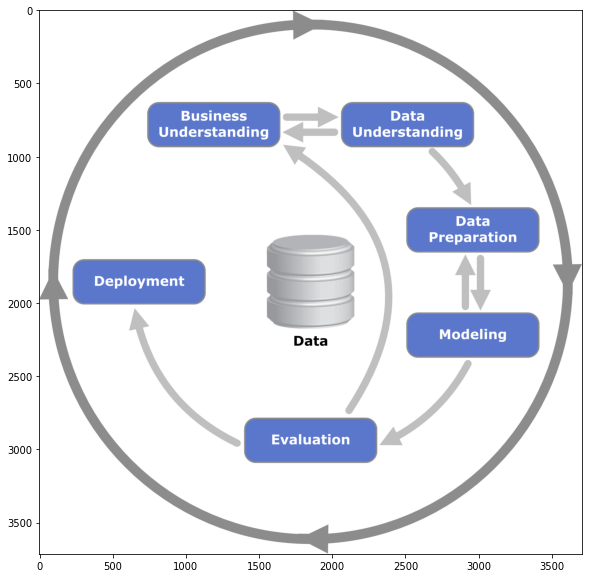

In [7]:
image3 = plt.imread("../input/crispdm/CRISP-DM_Process_Diagram.png")
plt.imshow(image3)

#### CRISP-DM Fase 1: Business Understanding

The objective of this problem is to model the daily flow in the "Santa Coloma de Gramenet" station from the rain stations, the upstream gauging stations and the historical flow records at this station.

##### Type of Machine Learning Problem:

It is a Supervised Regression problem: because it involves training an algorithm from a series of historical continuous data.

The objective variable of this problem is: the daily flow at the "Santa Coloma de Gramenet" gauging station.

The independent variables are the rainfall in the three stations that we have, the daily flows of the upstream gauging stations, and the historical data in the target station.

The algorithms that will be used to solve this problem are: Multiple Linear Regression, Gradient Boosting Regression, Support Vector Regression and Random Forest Regression

#### CRISP-DM Fase 2: Data Understanding

Let's load the libraries and metrics we need

In [11]:
!pip install hydroeval

In [68]:
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import json
%matplotlib inline
import hydroeval as he
from statsmodels.graphics import tsaplots
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy import stats

Let's import the dataset

In [361]:
df = pd.read_csv("../input/rainfall-and-runoff-data-for-the-bess-river-basin/all_stations.csv", index_col='fecha')
df

,Barcelona_fabra,Barcelona,Sabadell_aero,Garriga,Castellar,Llica,el_Mogent,Mogoda,Gramenet
fecha,,,,,,,,,
2003-01-01,0.0,0.0,0.0,0.254,0.032700,0.155,0.398500,0.120,3.627500
2003-01-02,0.0,0.0,NaN,0.254,0.028100,0.151,0.374500,0.106,3.947100
2003-01-03,0.0,0.0,NaN,0.246,0.022500,0.145,0.375000,0.101,4.017400
2003-01-04,0.0,0.0,0.0,0.251,0.030000,0.145,0.372000,0.099,3.931600
2003-01-05,18.1,16.4,2.1,0.241,0.032800,0.146,0.368600,0.097,3.791300
...,...,...,...,...,...,...,...,...,...
2010-12-27,0.0,0.0,0.0,0.238,0.090177,0.130,0.380753,0.007,3.674486
2010-12-28,0.0,0.0,0.0,0.234,0.090660,0.120,0.366378,0.004,3.666427
2010-12-29,NaN,0.0,NaN,0.223,0.090462,0.111,0.342472,0.000,3.579455


Once loaded, we can plot the dataset using the Matplotlib library

In [77]:
plt.rcParams['figure.figsize'] = (20, 10)

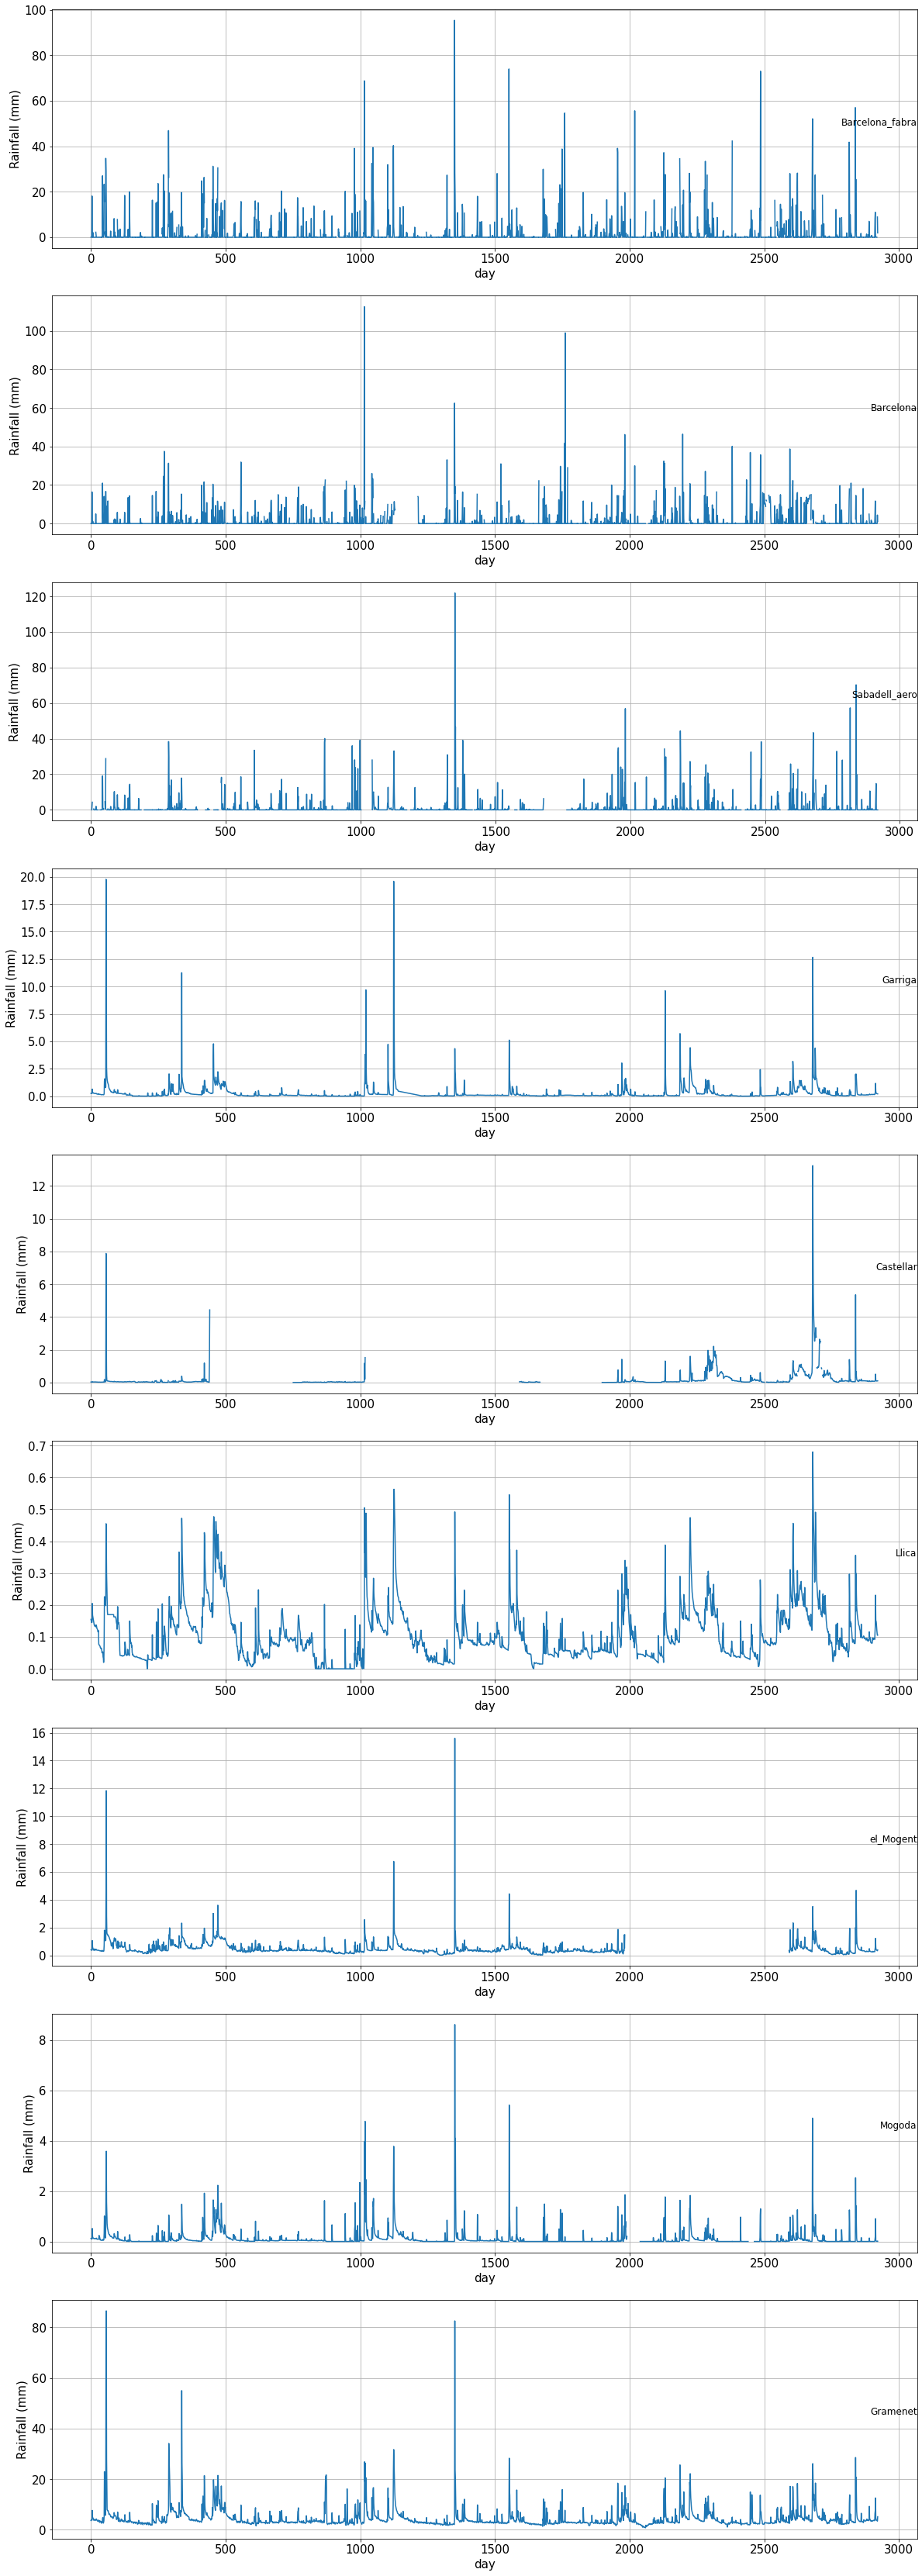

In [23]:
columns = [0, 1, 2, 3, 4, 5, 6, 7, 8]
i = 1
values = df.values
# define figure object and size
plt.figure(figsize=(20,60))
# plot each column with a for loop
for variable in columns:
     plt.subplot(len(columns), 1, i)
     plt.plot(values[:, variable])
     plt.xlabel('day',fontsize=15)
     plt.ylabel('Rainfall (mm)',fontsize=15)
     plt.title(df.columns[variable], y=0.5, loc='right')
     plt.tick_params(labelsize=15)
     plt.grid()
     plt.ioff()
     i += 1
plt.show()

<AxesSubplot:xlabel='fecha'>

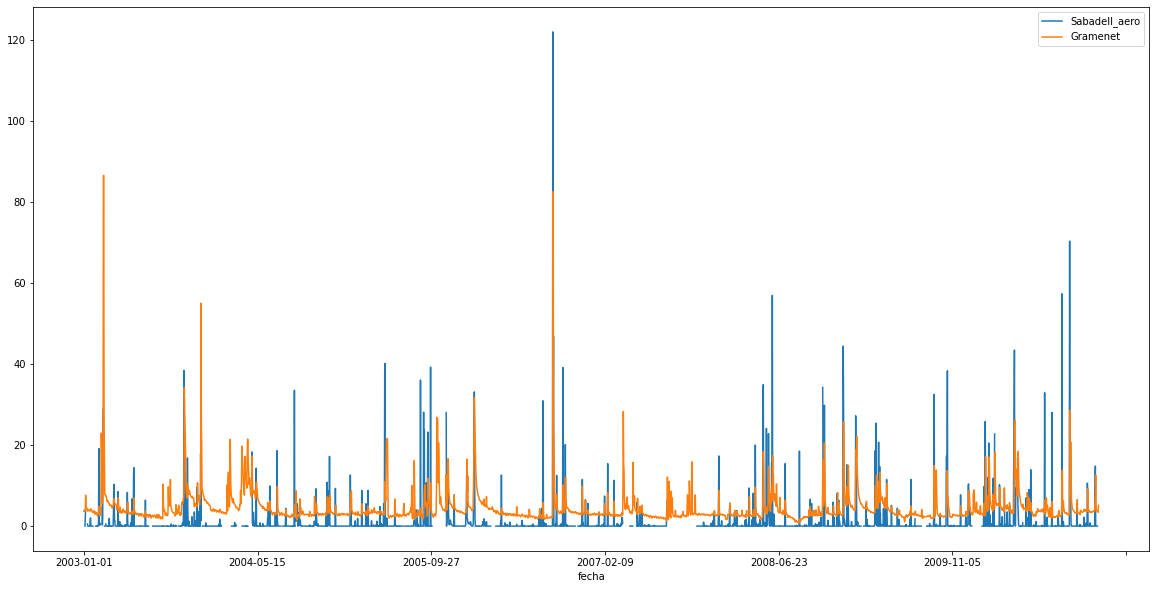

In [24]:
df[['Sabadell_aero', 'Gramenet']].plot()

Some descriptive analyzes

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2922 entries, 2003-01-01 to 2010-12-31
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Barcelona_fabra  2679 non-null   float64
 1   Barcelona        2699 non-null   float64
 2   Sabadell_aero    2516 non-null   float64
 3   Garriga          2922 non-null   float64
 4   Castellar        1789 non-null   float64
 5   Llica            2922 non-null   float64
 6   el_Mogent        2309 non-null   float64
 7   Mogoda           2852 non-null   float64
 8   Gramenet         2922 non-null   float64
dtypes: float64(9)
memory usage: 228.3+ KB


In [26]:
df.describe()

,Barcelona_fabra,Barcelona,Sabadell_aero,Garriga,Castellar,Llica,el_Mogent,Mogoda,Gramenet
count,2679.000000,2699.000000,2516.000000,2922.000000,1789.000000,2922.000000,2309.000000,2852.000000,2922.000000
mean,1.698470,1.539941,1.266494,0.283581,0.195427,0.105649,0.479607,0.119630,4.421081
std,6.116616,5.440818,5.539629,0.856069,0.613047,0.085916,0.567170,0.377305,4.311695
min,0.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.014000,0.000000,0.764272
25%,0.000000,0.000000,0.000000,0.046000,0.022900,0.045000,0.274500,0.000000,2.710300
50%,0.000000,0.000000,0.000000,0.085000,0.046200,0.083000,0.350600,0.024000,3.255550
75%,0.100000,0.000000,0.000000,0.231000,0.102444,0.146000,0.529200,0.079000,4.514250
max,95.400000,112.600000,121.900000,19.776000,13.247163,0.680000,15.605600,8.620000,86.495900


In [27]:
df.isnull().sum()

Barcelona_fabra     243
Barcelona           223
Sabadell_aero       406
Garriga               0
Castellar          1133
Llica                 0
el_Mogent           613
Mogoda               70
Gramenet              0
dtype: int64

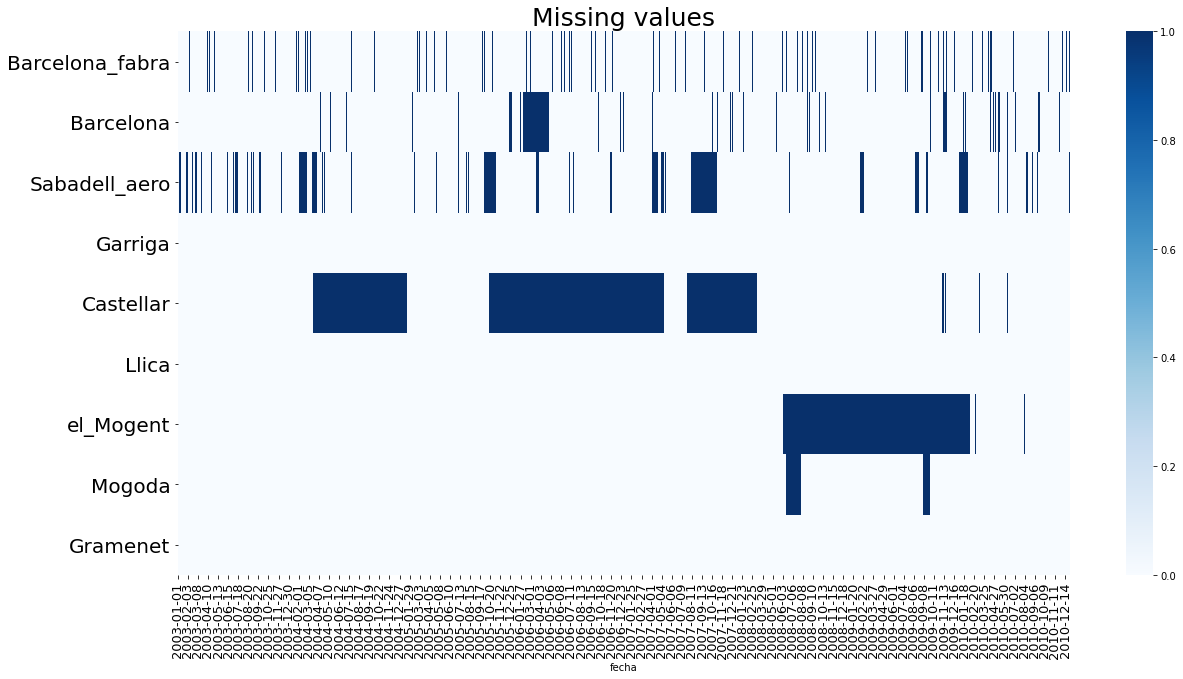

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing values', fontsize=25)

for i in ax.yaxis.get_major_ticks():
    i.label.set_fontsize(20)
for i in ax.xaxis.get_major_ticks():
    i.label.set_fontsize(13)

plt.show()

,Total,Percent
Castellar,1133,0.387748
el_Mogent,613,0.209788
Sabadell_aero,406,0.138946
Barcelona_fabra,243,0.083162
Barcelona,223,0.076318


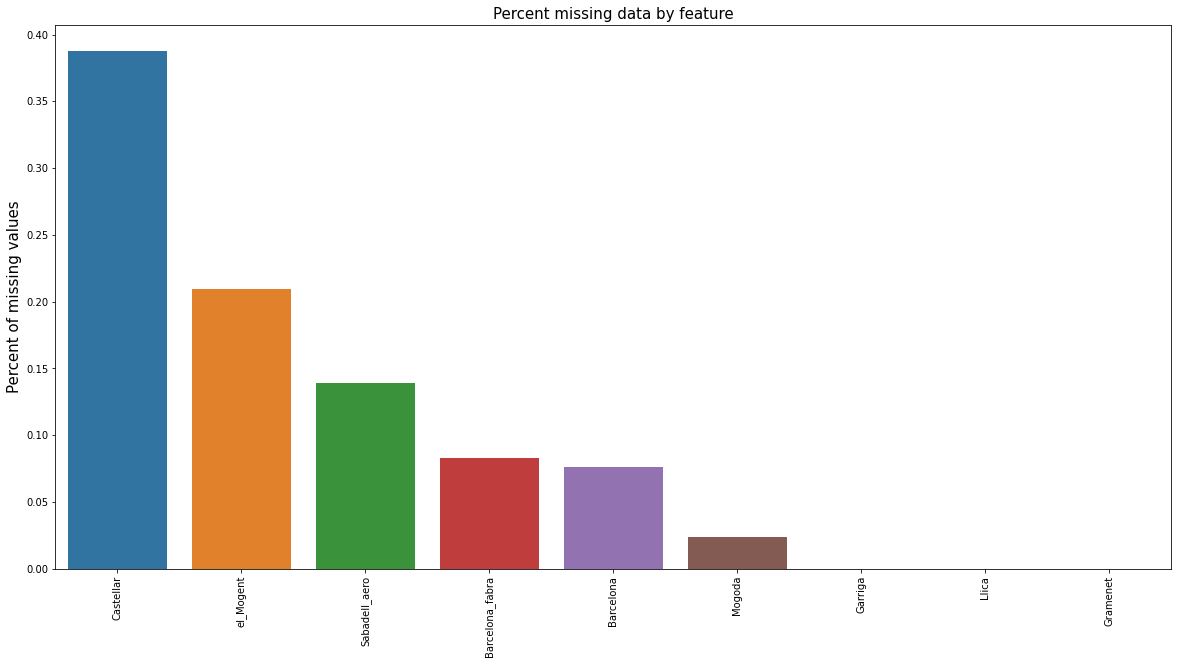

In [29]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots()
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

##### Conclusions

- From 06-06-2008, the el_Mogent gauging station has many null values
- The longest common period is from 01-01-2003 to 06-05-2008 (56.18%)
- In this period, the Castellar gauging station has a lot of null values
- Also in this period, apart from the Llica, el_Mogent, Mogoda and Gramenet stations, the others present some null values

It has been decided to: 
- Delete the records from 06-06-2008
- Remove the Castellar gauging station
- Eliminate the null values that remain in the other stations by the function .dropna()

#### CRISP-DM Fase 3: Data Preparation

In [362]:
#Selecting the common period
df = df.loc['2003-01-01':'2008-06-05']
df

,Barcelona_fabra,Barcelona,Sabadell_aero,Garriga,Castellar,Llica,el_Mogent,Mogoda,Gramenet
fecha,,,,,,,,,
2003-01-01,0.0,0.0,0.0,0.254,0.0327,0.155,0.3985,0.120,3.6275
2003-01-02,0.0,0.0,NaN,0.254,0.0281,0.151,0.3745,0.106,3.9471
2003-01-03,0.0,0.0,NaN,0.246,0.0225,0.145,0.3750,0.101,4.0174
2003-01-04,0.0,0.0,0.0,0.251,0.0300,0.145,0.3720,0.099,3.9316
2003-01-05,18.1,16.4,2.1,0.241,0.0328,0.146,0.3686,0.097,3.7913
...,...,...,...,...,...,...,...,...,...
2008-06-01,0.6,1.5,2.3,0.143,0.0354,0.165,0.4141,0.125,7.9588
2008-06-02,NaN,0.0,1.8,0.120,0.0161,0.191,0.3225,0.606,5.5666
2008-06-03,4.0,17.1,15.6,0.445,0.0109,0.234,1.4735,0.236,9.5464


In [363]:
#Deleting the "Castellar" gauging station
df = df.drop('Castellar', 1)
df

,Barcelona_fabra,Barcelona,Sabadell_aero,Garriga,Llica,el_Mogent,Mogoda,Gramenet
fecha,,,,,,,,
2003-01-01,0.0,0.0,0.0,0.254,0.155,0.3985,0.120,3.6275
2003-01-02,0.0,0.0,NaN,0.254,0.151,0.3745,0.106,3.9471
2003-01-03,0.0,0.0,NaN,0.246,0.145,0.3750,0.101,4.0174
2003-01-04,0.0,0.0,0.0,0.251,0.145,0.3720,0.099,3.9316
2003-01-05,18.1,16.4,2.1,0.241,0.146,0.3686,0.097,3.7913
...,...,...,...,...,...,...,...,...
2008-06-01,0.6,1.5,2.3,0.143,0.165,0.4141,0.125,7.9588
2008-06-02,NaN,0.0,1.8,0.120,0.191,0.3225,0.606,5.5666
2008-06-03,4.0,17.1,15.6,0.445,0.234,1.4735,0.236,9.5464


In [32]:
#The number of day with 0 m3/s flow rate in the target gauging station "Santa Coloma de Gramenet"
len(df.loc[df['Gramenet'] == 0])

0

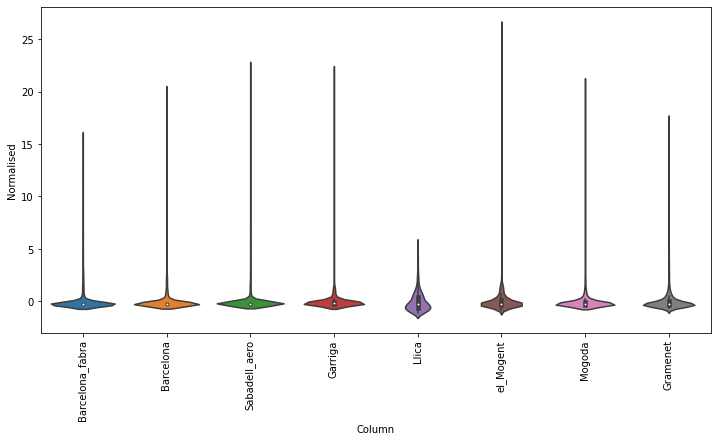

In [33]:
# calculate dataset mean and standard deviation
mean = df.mean()
std = df.std()
# normalise dataset with previously calculated values
df_std = (df - mean) / std
# create violin plot
df_std = df_std.melt(var_name='Column', value_name='Normalised')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalised', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1983 entries, 2003-01-01 to 2008-06-05
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Barcelona_fabra  1823 non-null   float64
 1   Barcelona        1829 non-null   float64
 2   Sabadell_aero    1659 non-null   float64
 3   Garriga          1983 non-null   float64
 4   Llica            1983 non-null   float64
 5   el_Mogent        1982 non-null   float64
 6   Mogoda           1983 non-null   float64
 7   Gramenet         1983 non-null   float64
dtypes: float64(8)
memory usage: 139.4+ KB


In [35]:
df.describe()

,Barcelona_fabra,Barcelona,Sabadell_aero,Garriga,Llica,el_Mogent,Mogoda,Gramenet
count,1823.000000,1829.000000,1659.000000,1983.000000,1983.000000,1982.000000,1983.000000,1983.000000
mean,1.627153,1.389284,1.136709,0.253048,0.096474,0.481110,0.130982,4.448977
std,5.975366,5.538945,5.395253,0.887543,0.085051,0.576195,0.407332,4.746821
min,0.000000,0.000000,0.000000,0.002000,0.000000,0.014000,0.000000,1.328600
25%,0.000000,0.000000,0.000000,0.046000,0.040000,0.283100,0.000000,2.718500
50%,0.000000,0.000000,0.000000,0.081000,0.075000,0.351050,0.030000,3.172200
75%,0.000000,0.000000,0.000000,0.195500,0.133000,0.528075,0.090000,4.420850
max,95.400000,112.600000,121.900000,19.776000,0.563000,15.605600,8.620000,86.495900


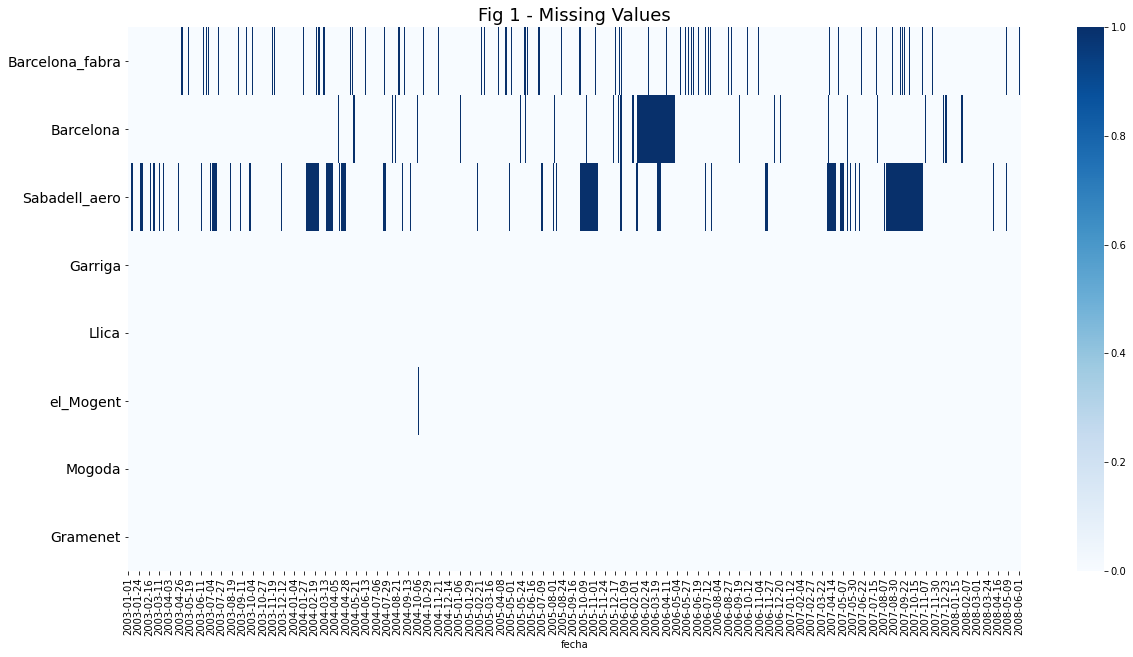

In [36]:
#Prospect the missing values again
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Fig 1 - Missing Values', fontsize=18)

for i in ax.yaxis.get_major_ticks():
    i.label.set_fontsize(14)

plt.show()

,Total,Percent
Sabadell_aero,324,0.163389
Barcelona_fabra,160,0.080686
Barcelona,154,0.077660
el_Mogent,1,0.000504
Garriga,0,0.000000


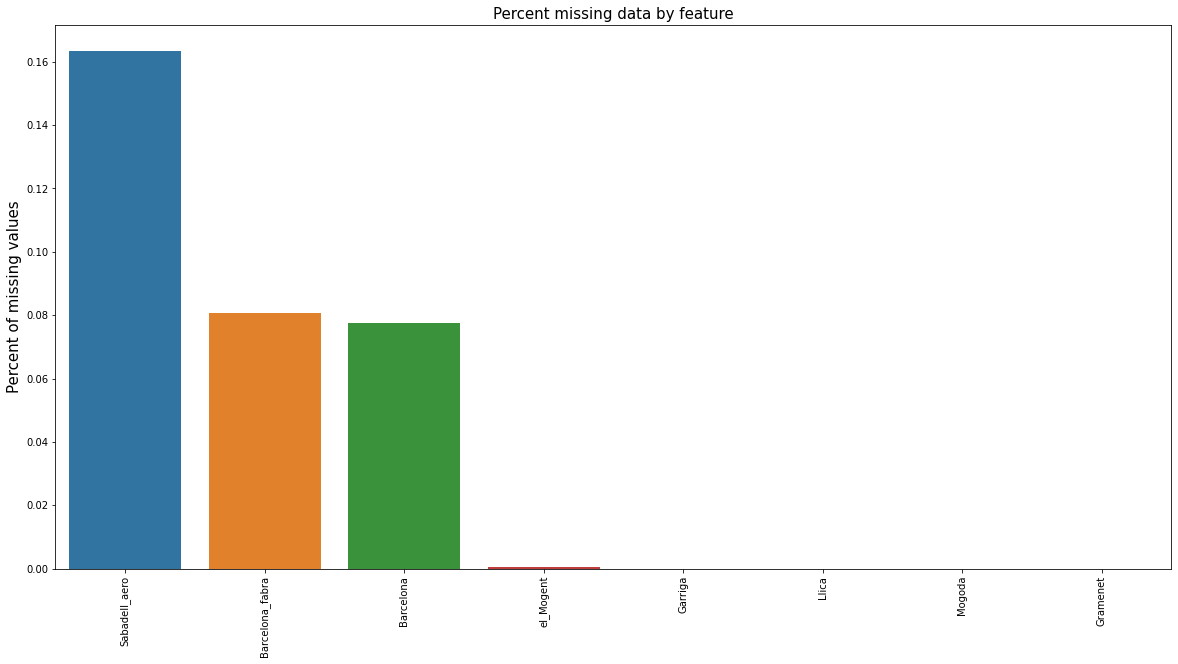

In [37]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots()
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

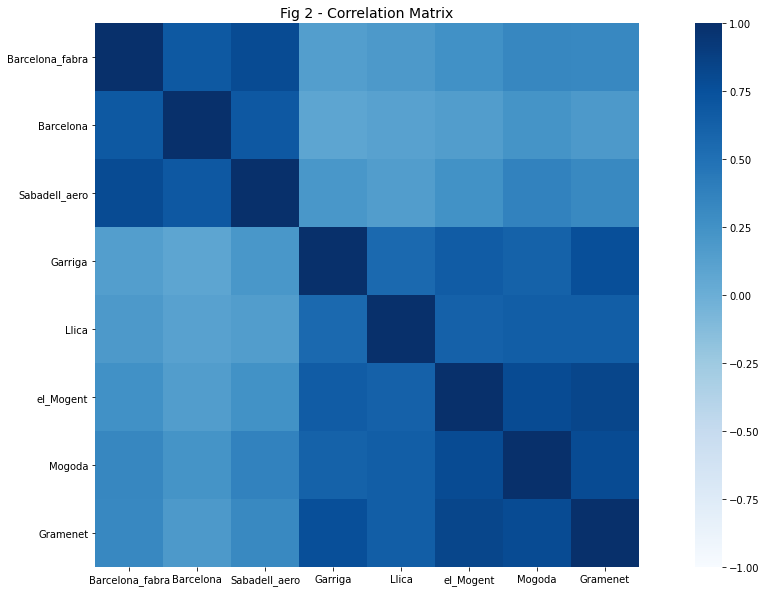

In [38]:
#Correlation heatmap
fig, ax = plt.subplots() 
ax.set_title('Fig 2 - Correlation Matrix', fontsize=14)
ax = sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0, cmap='Blues', square=True)

In [39]:
#Dataframe correlation
df.corr()

,Barcelona_fabra,Barcelona,Sabadell_aero,Garriga,Llica,el_Mogent,Mogoda,Gramenet
Barcelona_fabra,1.000000,0.687054,0.793372,0.142107,0.187065,0.250213,0.335920,0.327322
Barcelona,0.687054,1.000000,0.693229,0.079053,0.112999,0.148629,0.233710,0.186069
Sabadell_aero,0.793372,0.693229,1.000000,0.206246,0.152026,0.247949,0.367711,0.320179
Garriga,0.142107,0.079053,0.206246,1.000000,0.558836,0.657255,0.616467,0.758913
Llica,0.187065,0.112999,0.152026,0.558836,1.000000,0.623685,0.642459,0.640897
el_Mogent,0.250213,0.148629,0.247949,0.657255,0.623685,1.000000,0.794018,0.835158
Mogoda,0.335920,0.233710,0.367711,0.616467,0.642459,0.794018,1.000000,0.793789
Gramenet,0.327322,0.186069,0.320179,0.758913,0.640897,0.835158,0.793789,1.000000


In [364]:
#Convert index to datetime
df.index = pd.to_datetime(df.index)

In [365]:
#Deleting remaining missing values
df = df.dropna()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1404 entries, 2003-01-01 to 2008-06-05
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Barcelona_fabra  1404 non-null   float64
 1   Barcelona        1404 non-null   float64
 2   Sabadell_aero    1404 non-null   float64
 3   Garriga          1404 non-null   float64
 4   Llica            1404 non-null   float64
 5   el_Mogent        1404 non-null   float64
 6   Mogoda           1404 non-null   float64
 7   Gramenet         1404 non-null   float64
dtypes: float64(8)
memory usage: 98.7 KB


In [43]:
#Statistical results description
stats.describe(df)

DescribeResult(nobs=1404, minmax=(array([0.    , 0.    , 0.    , 0.002 , 0.    , 0.014 , 0.    , 1.3286]), array([ 95.4   ,  62.5   , 121.9   ,  19.591 ,   0.563 ,  15.6056,
         8.62  ,  82.5285])), mean=array([1.3031339 , 1.22970085, 1.26103989, 0.20834544, 0.0876104 ,
       0.45222779, 0.10260256, 4.12589845]), variance=array([2.62118362e+01, 1.79495021e+01, 3.35467419e+01, 5.61185134e-01,
       5.90863000e-03, 2.90984687e-01, 1.28367843e-01, 1.49778765e+01]), skewness=array([ 7.99751439,  6.05713723,  9.97165604, 17.58528442,  2.09455561,
       17.46069882, 12.96664692,  9.50757844]), kurtosis=array([100.21597481,  53.38169099, 153.72097569, 389.05135682,
         6.87697403, 456.39438395, 252.52818437, 148.74530904]))

In [366]:
#Lag creation
def lag_creation(df, lag_start, lag_end, columns, inplace=False, freq=1):
    if not inplace:
        df = df.copy()
    for col in columns:
        for i in range(lag_start, lag_end, freq):
            df["lag_"+str(i)+"_"+col] = df[col].shift(i)
    if not inplace:
        return df

#Encoding the cyclical properties of time
def date_features(df, inplace=False):
    if not inplace:
        df = df.copy()
    df.index = pd.to_datetime(df.index)
    df['day_sin'] = np.sin(df.index.dayofweek*(2.*np.pi/7))
    df['day_cos'] = np.cos(df.index.dayofweek*(2.*np.pi/7))
    df['month_sin'] = np.sin(df.index.dayofweek*(2.*np.pi/12))
    df['month_cos'] = np.cos(df.index.dayofweek*(2.*np.pi/12))
    if not inplace:
        return df

#Data normalization
from sklearn.preprocessing import MinMaxScaler
def Normalize_columns(df, columns, inplace=False):
    if not inplace:
        df = df.copy()
    sc = MinMaxScaler()
    df[columns] = sc.fit_transform(df[columns])
    if not inplace:
        return df

In [367]:
#Cross-correlation
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [368]:
df.head(2000)

,Barcelona_fabra,Barcelona,Sabadell_aero,Garriga,Llica,el_Mogent,Mogoda,Gramenet
fecha,,,,,,,,
2003-01-01,0.0,0.0,0.0,0.254,0.155,0.3985,0.120,3.6275
2003-01-04,0.0,0.0,0.0,0.251,0.145,0.3720,0.099,3.9316
2003-01-05,18.1,16.4,2.1,0.241,0.146,0.3686,0.097,3.7913
2003-01-06,1.0,0.2,4.3,0.644,0.205,1.0558,0.516,7.6332
2003-01-11,0.0,0.0,0.5,0.269,0.147,0.3740,0.125,3.9437
...,...,...,...,...,...,...,...,...
2008-05-31,6.9,14.3,7.0,0.149,0.138,0.1944,0.000,3.6330
2008-06-01,0.6,1.5,2.3,0.143,0.165,0.4141,0.125,7.9588
2008-06-03,4.0,17.1,15.6,0.445,0.234,1.4735,0.236,9.5464


Analyze which lags are more related to the flow

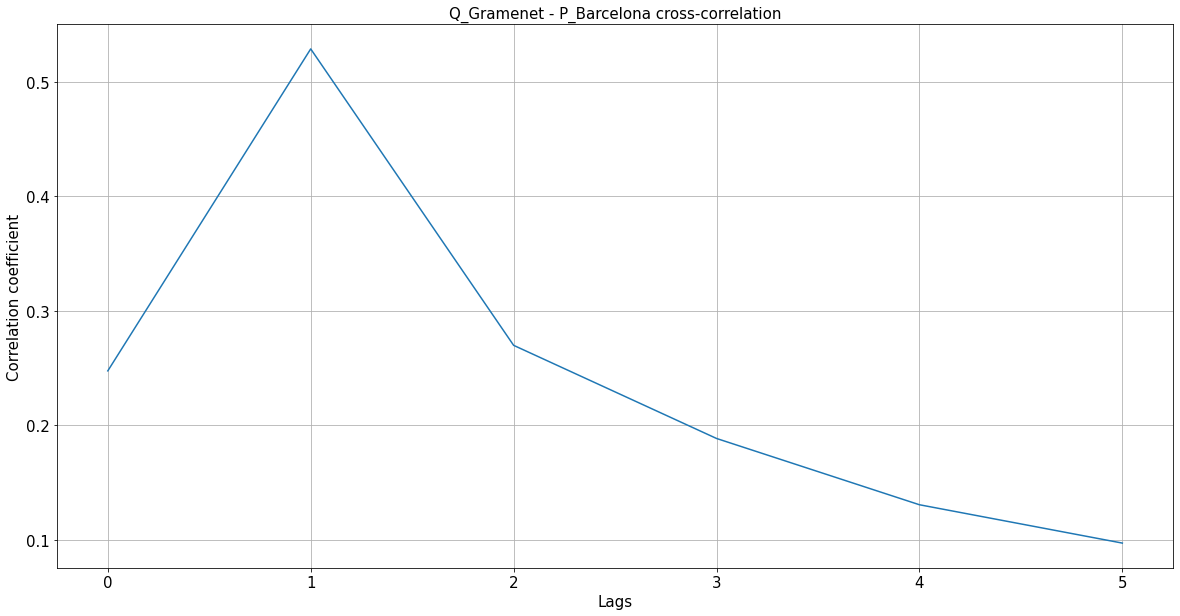

In [47]:
plt.plot(np.arange(0, 6), [crosscorr(df['Gramenet'], df['Barcelona'], lag) for lag in range(0, 6)])
plt.title('Q_Gramenet - P_Barcelona cross-correlation', fontsize=15)
plt.xlabel('Lags',fontsize=15)
plt.ylabel('Correlation coefficient',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.ioff()
plt.show();

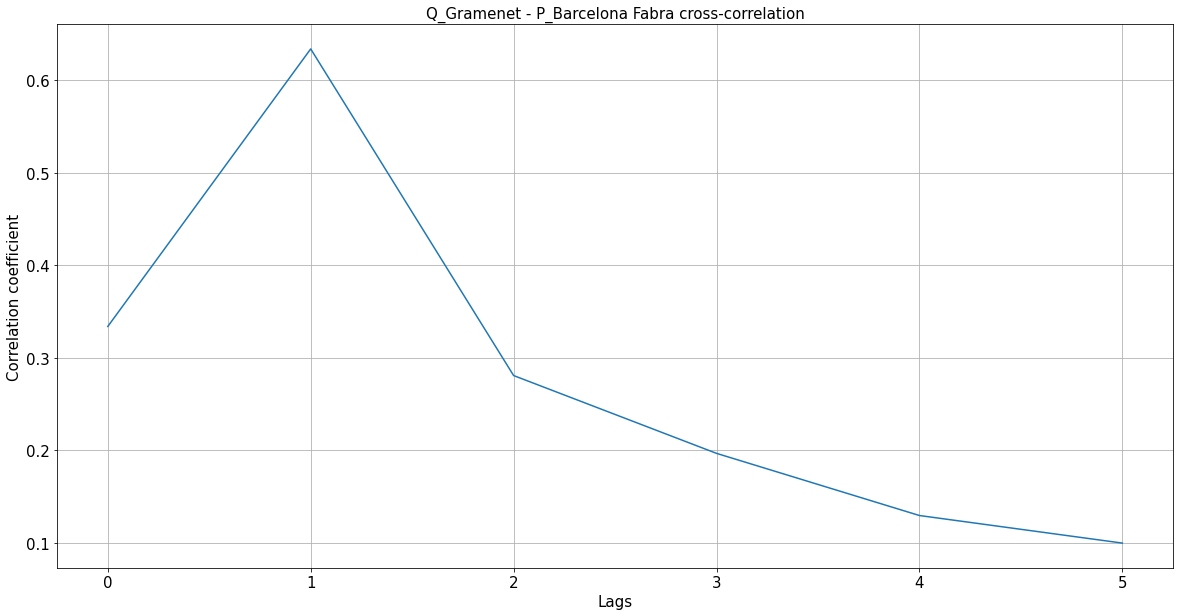

In [48]:
plt.plot(np.arange(0, 6), [crosscorr(df['Gramenet'], df['Barcelona_fabra'],lag) for lag in range(0, 6)])
plt.title('Q_Gramenet - P_Barcelona Fabra cross-correlation', fontsize=15)
plt.xlabel('Lags',fontsize=15)
plt.ylabel('Correlation coefficient',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.ioff()
plt.show();

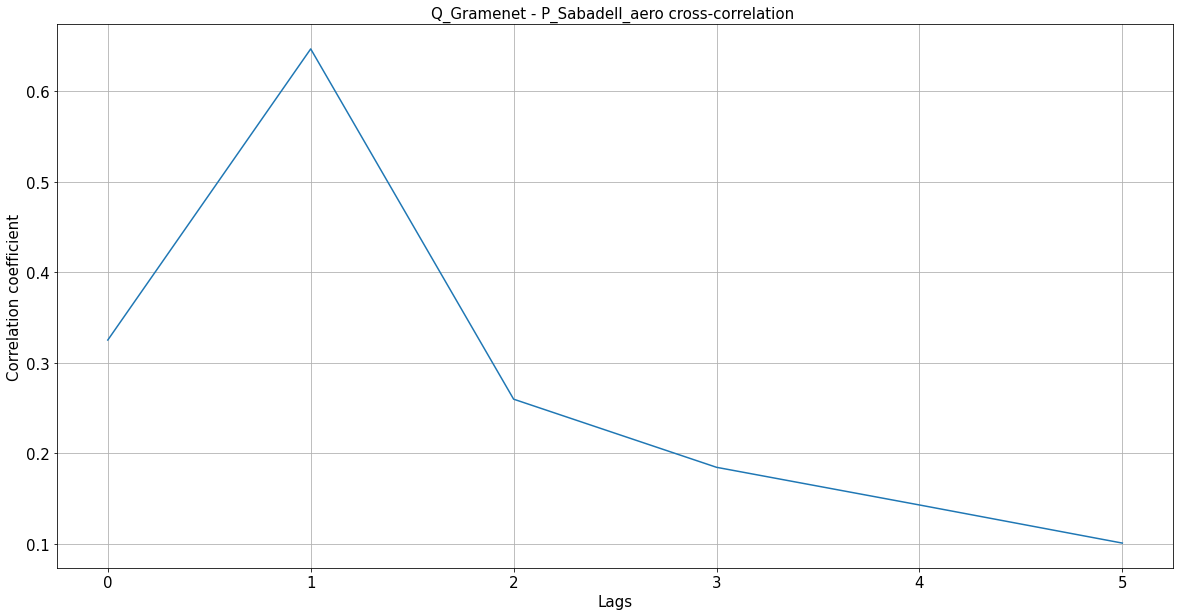

In [49]:
plt.plot(np.arange(0, 6), [crosscorr(df['Gramenet'], df['Sabadell_aero'], lag) for lag in range(0, 6)])
plt.title('Q_Gramenet - P_Sabadell_aero cross-correlation ', fontsize = 15)
plt.xlabel('Lags',fontsize=15)
plt.ylabel('Correlation coefficient',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.ioff()
plt.show();

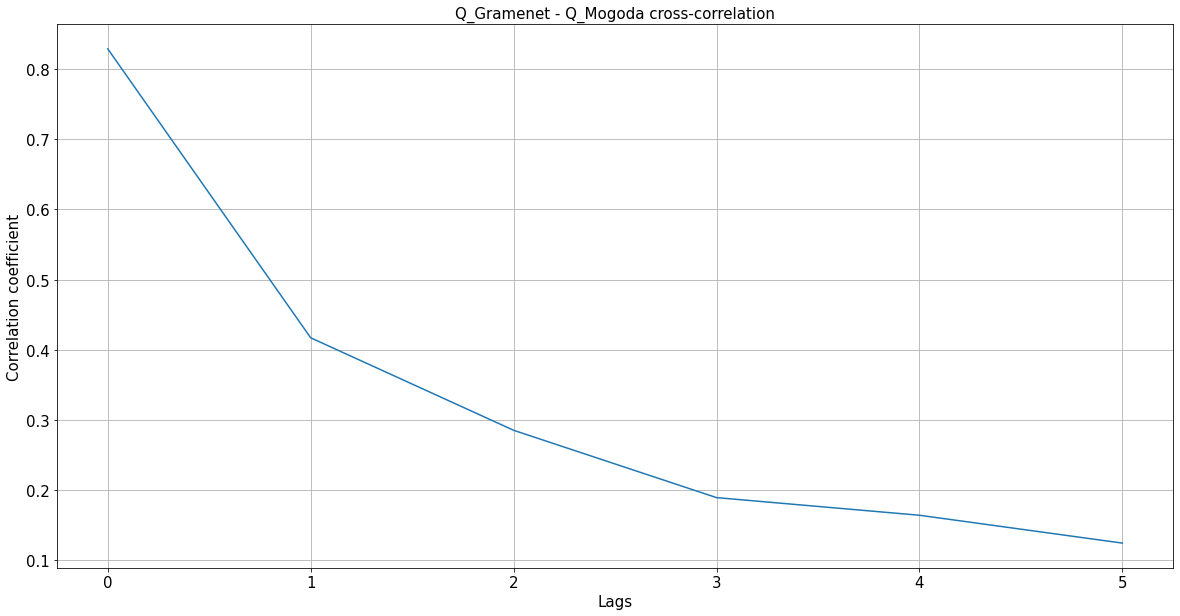

In [50]:
plt.plot(np.arange(0, 6), [crosscorr(df['Gramenet'], df['Mogoda'], lag) for lag in range(0, 6)])
plt.title('Q_Gramenet - Q_Mogoda cross-correlation', fontsize = 15)
plt.xlabel('Lags',fontsize=15)
plt.ylabel('Correlation coefficient',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.ioff()
plt.show();

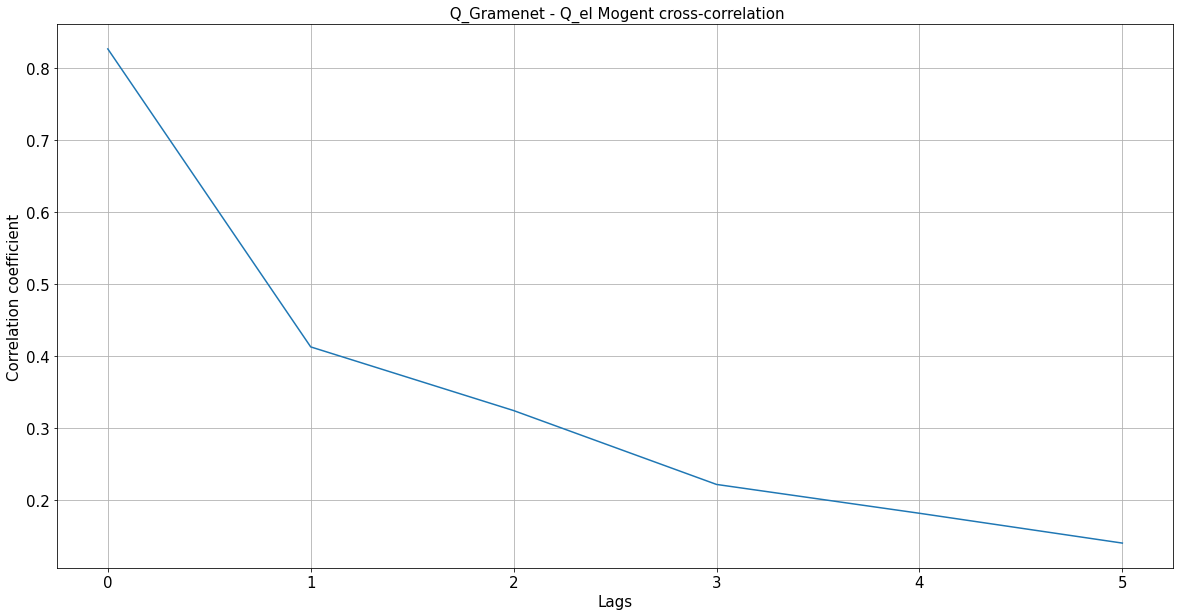

In [51]:
plt.plot(np.arange(0, 6), [crosscorr(df['Gramenet'], df['el_Mogent'], lag) for lag in range(0, 6)])
plt.title(' Q_Gramenet - Q_el Mogent cross-correlation', fontsize=15)
plt.xlabel('Lags',fontsize=15)
plt.ylabel('Correlation coefficient',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.ioff()
plt.show();

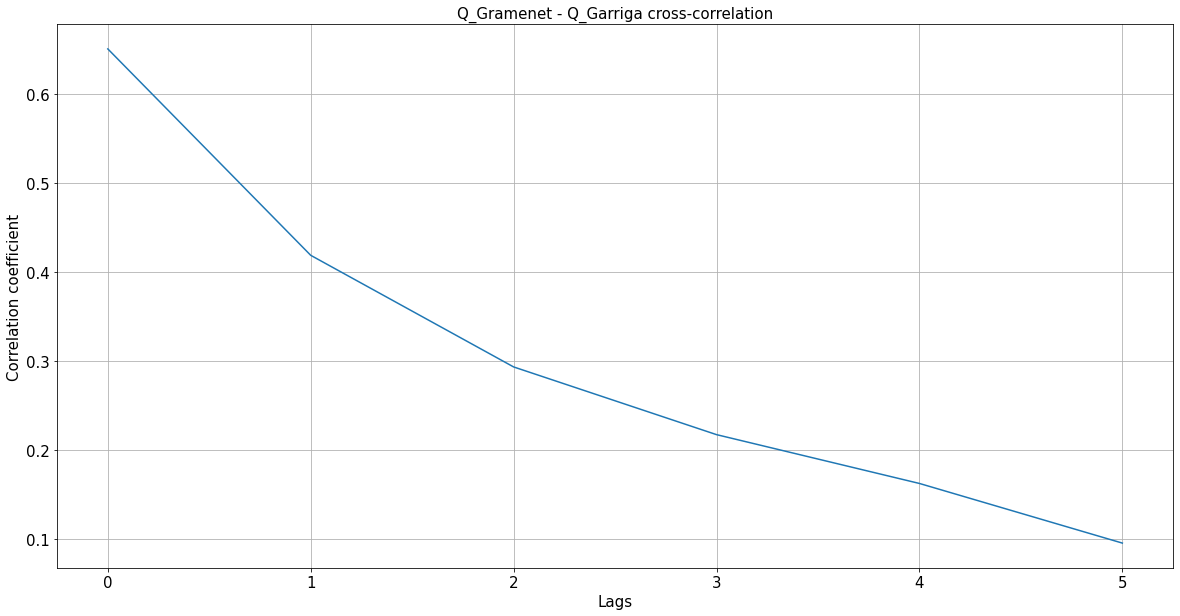

In [52]:
plt.plot(np.arange(0, 6), [crosscorr(df['Gramenet'], df['Garriga'], lag) for lag in range(0, 6)])
plt.title('Q_Gramenet - Q_Garriga cross-correlation', fontsize= 15)
plt.xlabel('Lags',fontsize=15)
plt.ylabel('Correlation coefficient',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.ioff()
plt.show();

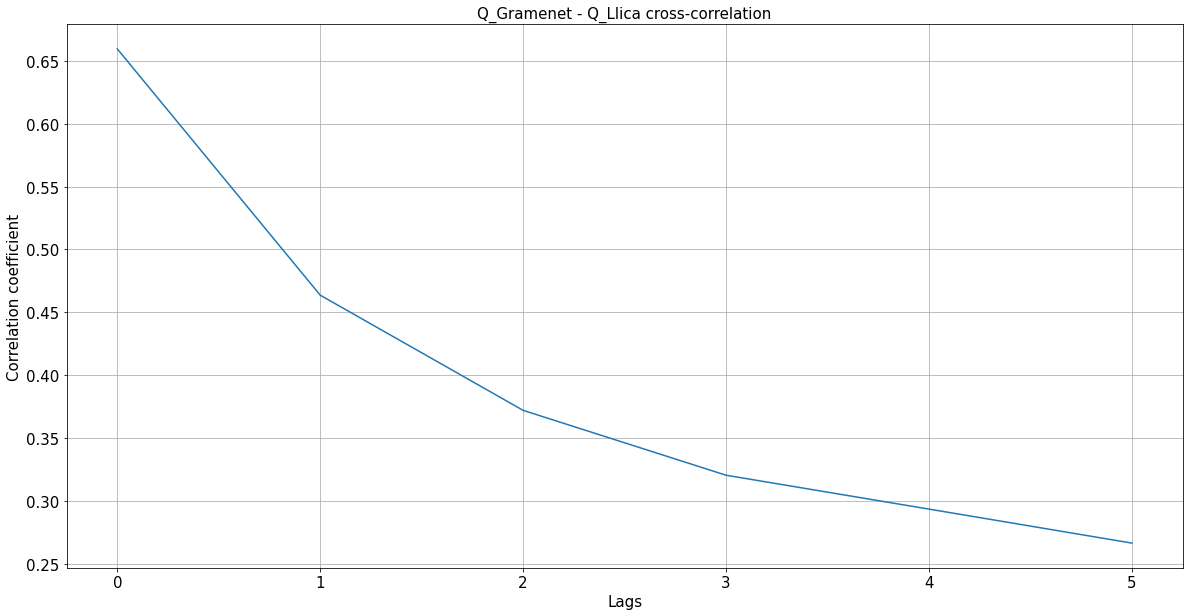

In [53]:
plt.plot(np.arange(0, 6), [crosscorr(df['Gramenet'], df['Llica'], lag) for lag in range(0, 6)])
plt.title('Q_Gramenet - Q_Llica cross-correlation', fontsize=15)
plt.xlabel('Lags',fontsize=15)
plt.ylabel('Correlation coefficient',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.ioff()
plt.show();

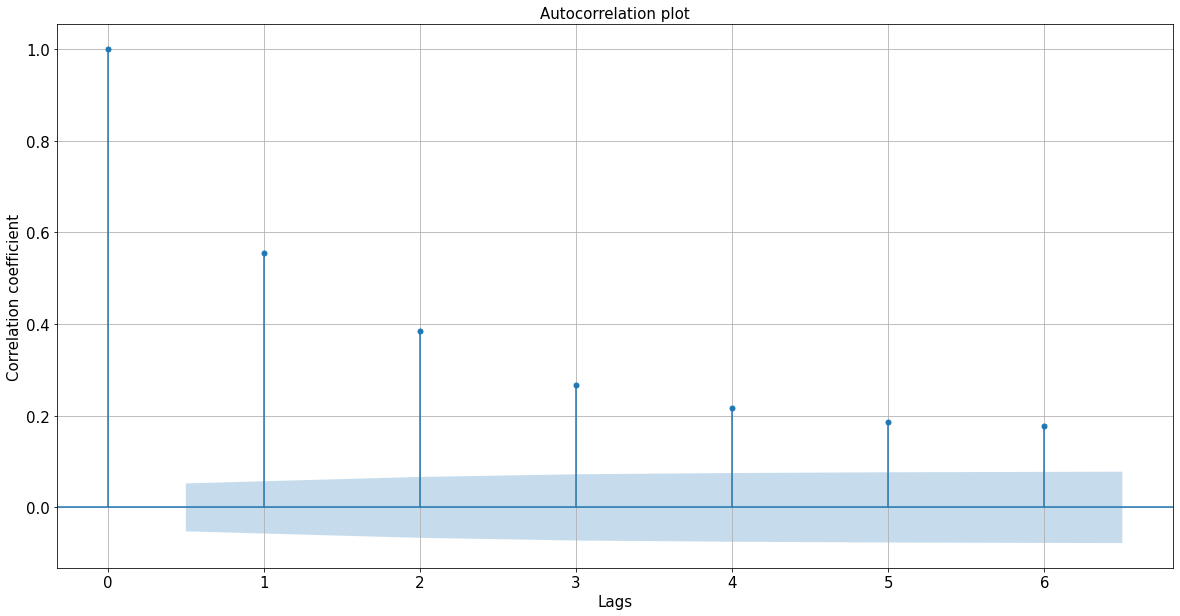

In [54]:
# Display the autocorrelation plot of the 'Gramenet' flow time serie
fig = tsaplots.plot_acf(df['Gramenet'], lags=6)
plt.title('Autocorrelation plot', fontsize= 15)
plt.xlabel('Lags',fontsize=15)
plt.ylabel('Correlation coefficient',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.ioff()
plt.show()

### Selecting data features 

First, let's model the flow discharge in the target station "Santa Coloma de Gramenet" without considering the historical flow in this gauging station, and by considering only one lag for each of the stations used.

In [369]:
df['y'] = df['Gramenet']
freq=1

Normalize_columns(df, ['Barcelona', 'Barcelona_fabra', 'Sabadell_aero', 'Garriga', 'Llica', 'el_Mogent', 'Mogoda', 'Gramenet'], inplace=True)
lag_creation(df, 1, 2, ['Barcelona'], inplace=True, freq=freq)
lag_creation(df, 1, 2, ['Barcelona_fabra'], inplace=True, freq=freq)
lag_creation(df, 1, 2, ['Sabadell_aero'], inplace=True, freq=freq)
lag_creation(df, 1, 2, ['Garriga'], inplace=True, freq=freq)
lag_creation(df, 1, 2, ['Llica'], inplace=True, freq=freq)
lag_creation(df, 1, 2, ['el_Mogent'], inplace=True, freq=freq)
lag_creation(df, 1, 2, ['Mogoda'], inplace=True, freq=freq)
date_features(df, inplace=True)
df.dropna(inplace=True)
del df['Gramenet']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [56]:
#data features
df.columns

Index(['Barcelona_fabra', 'Barcelona', 'Sabadell_aero', 'Garriga', 'Llica',
       'el_Mogent', 'Mogoda', 'y', 'lag_1_Barcelona', 'lag_1_Barcelona_fabra',
       'lag_1_Sabadell_aero', 'lag_1_Garriga', 'lag_1_Llica',
       'lag_1_el_Mogent', 'lag_1_Mogoda', 'day_sin', 'day_cos', 'month_sin',
       'month_cos'],
      dtype='object')

In [57]:
df.head()

,Barcelona_fabra,Barcelona,Sabadell_aero,Garriga,Llica,el_Mogent,Mogoda,y,lag_1_Barcelona,lag_1_Barcelona_fabra,lag_1_Sabadell_aero,lag_1_Garriga,lag_1_Llica,lag_1_el_Mogent,lag_1_Mogoda,day_sin,day_cos,month_sin,month_cos
fecha,,,,,,,,,,,,,,,,,,,
2003-01-04,0.000000,0.0000,0.000000,0.012711,0.257549,0.022961,0.011485,3.9316,0.0000,0.000000,0.000000,0.012864,0.275311,0.024661,0.013921,-0.974928,-0.222521,5.000000e-01,-0.866025
2003-01-05,0.189727,0.2624,0.017227,0.012201,0.259325,0.022743,0.011253,3.7913,0.0000,0.000000,0.000000,0.012711,0.257549,0.022961,0.011485,-0.781831,0.623490,1.224647e-16,-1.000000
2003-01-06,0.010482,0.0032,0.035275,0.032773,0.364121,0.066818,0.059861,7.6332,0.2624,0.189727,0.017227,0.012201,0.259325,0.022743,0.011253,0.000000,1.000000,0.000000e+00,1.000000
2003-01-11,0.000000,0.0000,0.004102,0.013630,0.261101,0.023089,0.014501,3.9437,0.0032,0.010482,0.035275,0.032773,0.364121,0.066818,0.059861,-0.974928,-0.222521,5.000000e-01,-0.866025
2003-01-12,0.000000,0.0000,0.000000,0.013120,0.255773,0.022730,0.012877,3.6819,0.0000,0.000000,0.004102,0.013630,0.261101,0.023089,0.014501,-0.781831,0.623490,1.224647e-16,-1.000000


Split the dataset into training and test datasets

In [439]:
X = df.loc[:, df.columns!='y']
y = df['y']
train = df.iloc[:int(len(df)*0.80)]
test = df.iloc[int(len(df)*0.80):]

In [440]:
X_train = train.dropna().drop('y', axis=1)
y_train = train['y']

X_test = test.dropna().drop('y', axis=1)
y_test = test['y']
test = test.dropna().drop('y', axis=1)

X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

#### CRISP-DM Fases 4 & 5: Modeling and Evaluation

In [60]:
#Load the Regression Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

### Multiple Linear Regression

In [387]:
# Training the MLR
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

Training period

In [388]:
y_train = reg.predict(X_train)

In [389]:
mse =  mean_squared_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print('MSE =', mse)

MSE = 3.1784067885613783


In [390]:
mae = mean_absolute_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print("MAE =", mae)

MAE = 0.7797861567227032


In [391]:
r2 = r2_score(df.iloc[:int(len(df)*0.80)].y, y_train)
print("R2 =", r2)

R2 = 0.8188186235514056


In [392]:
ce = he.evaluator(he.nse, df.iloc[:int(len(df)*0.80)].y, y_train)
print("CE =", ce)

CE = [0.77872832]


Test period

In [393]:
y = reg.predict(X_test)

In [394]:
test['y'] = y

In [395]:
mse= mean_squared_error(df.iloc[int(len(df)*0.80):].y, test.y)
print("MSE =", mse)

MSE = 0.6492653924490047


In [396]:
mae = mean_absolute_error(df.iloc[int(len(df)*0.80):].y, test.y)
print("MAE =", mae)

MAE = 0.5018996506505163


In [397]:
r2= r2_score(df.iloc[int(len(df)*0.80):].y, test.y)
print('R2 =',r2)

R2 = 0.8194321855876585


In [398]:
ce= he.evaluator(he.nse, df.iloc[int(len(df)*0.80):].y, test.y)
print('CE =',ce)

CE = [0.80794896]


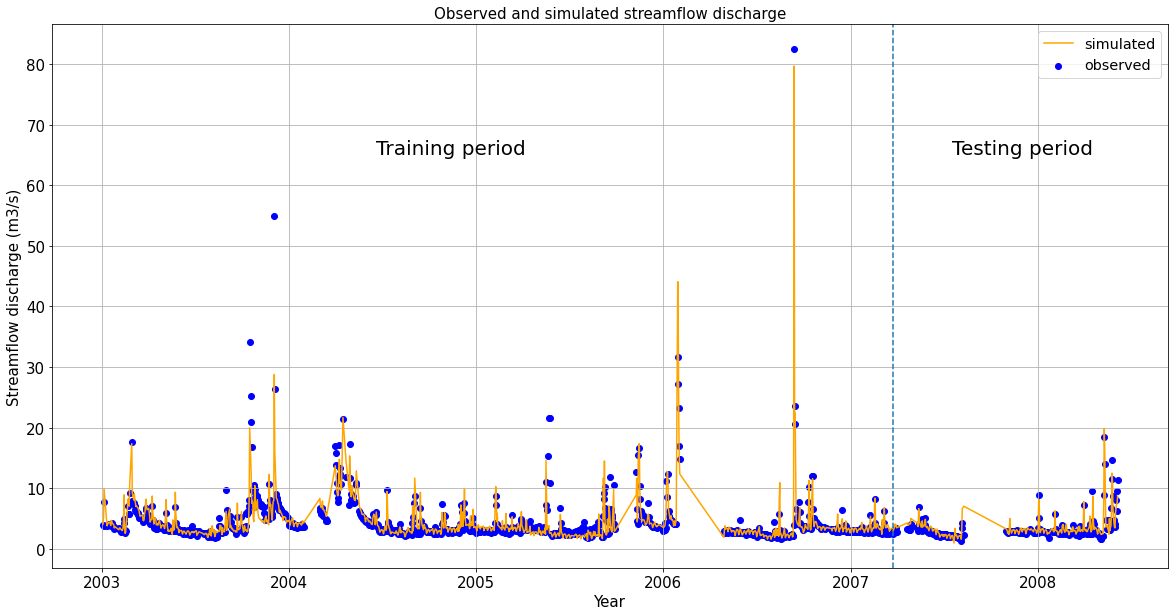

In [399]:
# Hydrograph plot for both training and test periods
plt.scatter(df.iloc[int(len(df)*0.80):].index, df.iloc[int(len(df)*0.80):].y, color ='b', label= "observed")
plt.scatter(df.iloc[:int(len(df)*0.80)].index, df.iloc[:int(len(df)*0.80)].y, color ='b')
plt.plot(df.iloc[int(len(df)*0.80):].index, test['y'], 'orange', label="simulated")
plt.plot(df.iloc[:int(len(df)*0.80)].index, y_train, 'orange')
plt.axvline(13596, 0, 80, linestyle='--')
plt.figtext(0.75, 0.7, "Testing period", fontsize = 20)
plt.figtext(0.35, 0.7, "Training period", fontsize = 20)
plt.title("Observed and simulated streamflow discharge", fontsize=15)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Streamflow discharge (m3/s)',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.legend(fontsize="x-large")
plt.show()

In [400]:
# MLR interception
Intercept=reg.intercept_
Intercept

1.3849177183661836

In [401]:
# MLR coefficients
Coefficients=reg.coef_
Coefficients

array([10.69955338, -2.10885021, -4.17639059, 18.03800362,  7.05231142,
       30.78924603, 13.35561054,  3.66337905,  8.8844766 ,  9.32797234,
        5.88963554, -2.7686622 ,  4.1474829 , -1.5876765 , -0.22284191,
        0.08073451,  0.76746745,  0.21916047])

<BarContainer object of 18 artists>

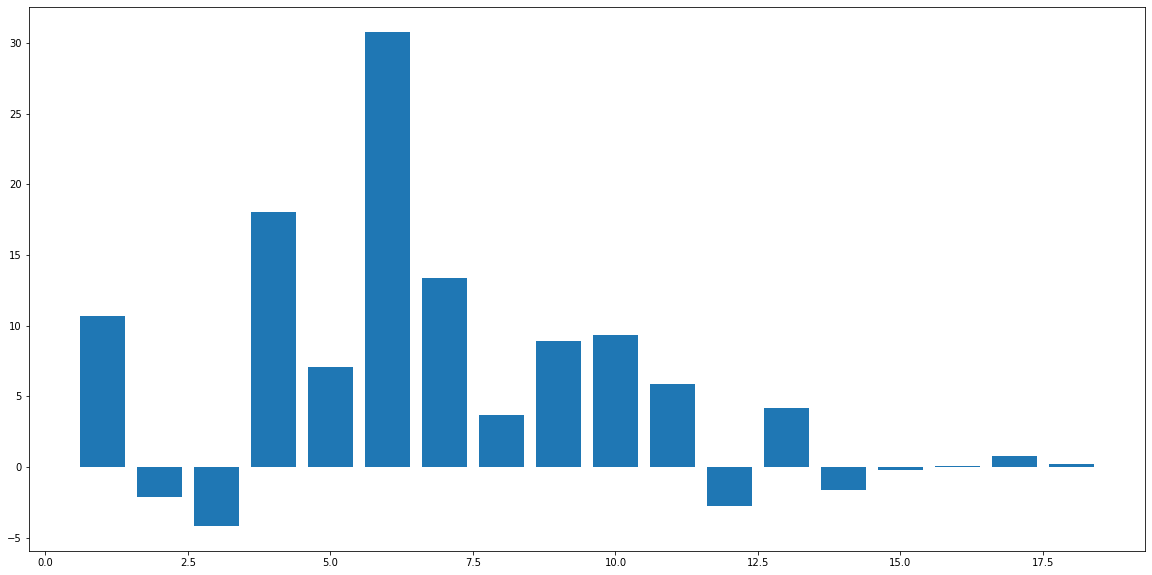

In [402]:
# MLR coefficients plot
plt.bar([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], # train.dropna().drop('y', axis=1).columns
        
        [10.69955338, -2.10885021, -4.17639059, 18.03800362,  7.05231142,
       30.78924603, 13.35561054,  3.66337905,  8.8844766 ,  9.32797234,
        5.88963554, -2.7686622 ,  4.1474829 , -1.5876765 , -0.22284191,
        0.08073451,  0.76746745,  0.21916047]) # reg.coef_

### Gradient Boosting Regressor

In [84]:
#GBR hyperparameters
parameters = {'n_estimators'     : [430,450,470,490],
              'max_features'     : [0.02,0.03,0.04,0.05],
              'learning_rate'    : [0.02,0.04,0.06,0.08,0.1],
              'subsample'        : [0.2,0.3,0.4,0.5],              
              'max_depth'        : [5,6,7,8],
              }

In [85]:
#Time counter function
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [137]:
gbr = GradientBoostingRegressor()

In [108]:
#Grid search hyperparameters tuning
rndm_GBR = GridSearchCV(estimator=gbr, param_grid = parameters, cv = 5, n_jobs=2, verbose=3)

In [113]:
from datetime import datetime

start_time = timer(None)
rndm_GBR.fit(X_train, y_train)
timer(start_time)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits

 Time taken: 0 hours 15 minutes and 20.52 seconds.


In [ ]:
#GBR optimal hyperparameters
rndm_GBR.best_params_

In [411]:
#Training the GBR with the optimal hyperparameters
gbr = GradientBoostingRegressor(learning_rate=0.04, max_depth= 5, max_features= 0.02, n_estimators= 430, subsample= 0.2)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.04, max_depth=5, max_features=0.02,
                          n_estimators=430, subsample=0.2)

Training period

In [412]:
y_train = gbr.predict(X_train)

In [413]:
mse =  mean_squared_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print('MSE =', mse)

MSE = 3.169764071790011


In [414]:
mae = mean_absolute_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print("MAE =", mae)

MAE = 0.7614492337699179


In [415]:
r2 = r2_score(df.iloc[:int(len(df)*0.80)].y, y_train)
print("R2 =", r2)

R2 = 0.8193112915530368


In [416]:
ce = he.evaluator(he.nse, df.iloc[:int(len(df)*0.80)].y, y_train)
print("CE =", ce)

CE = [0.76727725]


Testing period

In [417]:
y = gbr.predict(X_test)

In [418]:
test['y'] = y

In [419]:
mse = mean_squared_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MSE =', mse)

MSE = 0.6351173114057002


In [420]:
mae = mean_absolute_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MAE =', mae)

MAE = 0.4974336038235403


In [421]:
r2 = r2_score(df.iloc[int(len(df)*0.80):].y, y)
print('R2 = ', r2)

R2 =  0.8233669218323888


In [422]:
#CE of Nash
ce= he.evaluator(he.nse, df.iloc[int(len(df)*0.80):].y, test.y)
print('CE =', ce)

CE = [0.81587663]


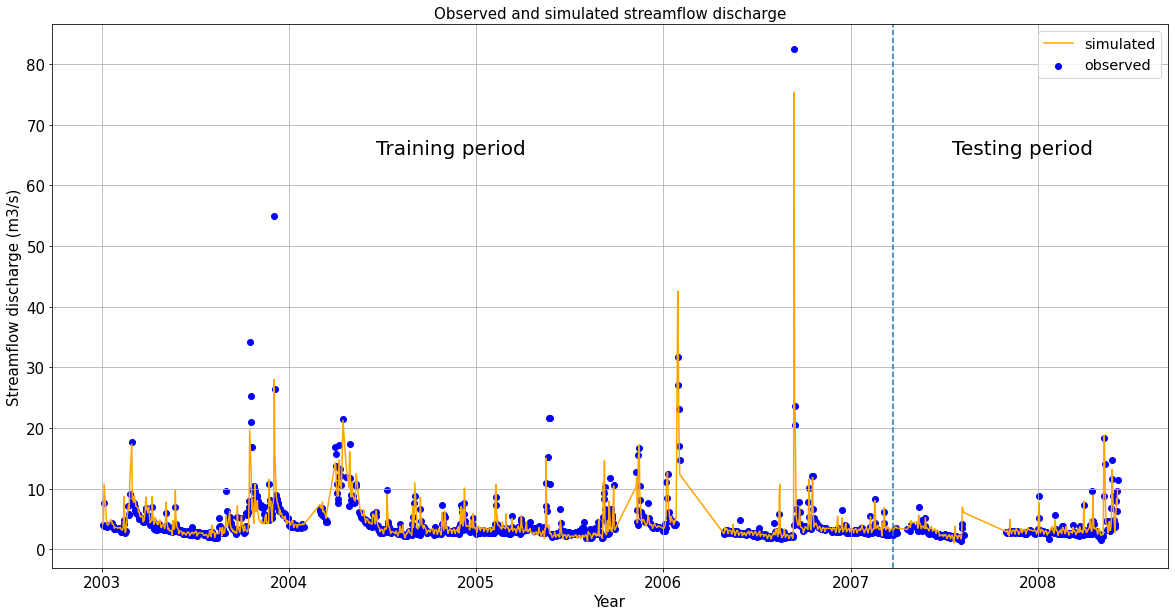

In [423]:
# Hydrograph plot for both training and test periods
plt.scatter(df.iloc[int(len(df)*0.80):].index, df.iloc[int(len(df)*0.80):].y, color ='b', label= "observed")
plt.scatter(df.iloc[:int(len(df)*0.80)].index, df.iloc[:int(len(df)*0.80)].y, color ='b')
plt.plot(df.iloc[int(len(df)*0.80):].index, test['y'], 'orange', label="simulated")
plt.plot(df.iloc[:int(len(df)*0.80)].index, y_train, 'orange')
plt.axvline(13596, 0, 80, linestyle='--')
plt.figtext(0.75, 0.7, "Testing period", fontsize = 20)
plt.figtext(0.35, 0.7, "Training period", fontsize = 20)
plt.title("Observed and simulated streamflow discharge", fontsize=15)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Streamflow discharge (m3/s)',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.legend(fontsize="x-large")
plt.show()

### Support Vector Regression

In [ ]:
#SVR hyperparameters
param={
  "C"        :  [0.1,1.0,10,100,1000],
 "epsilon"   :  [0.00001,0.0001,0.001,0.01,0.1,1],
 "gamma"     :  [0.0001,0.001,0.01,0.1,1],
}

In [ ]:
#Time counter
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
#Grid search hyperparameters tuning
modelsvr = SVR(kernel='rbf')
grids = GridSearchCV(modelsvr,param,cv=5,n_jobs = 2, verbose = 3)

In [ ]:
from datetime import datetime

start_time = timer(None)
grids.fit(X_train, y_train)
timer(start_time)

In [ ]:
#The optimal SVR hyperparameters
grids.best_params_

In [426]:
#Training the SVR with the optimal hyperparameters
modelsvr = SVR(kernel='rbf', C=100, epsilon=0.0001, gamma=0.1)
modelsvr.fit(X_train, y_train)

SVR(C=100, epsilon=0.0001, gamma=0.1)

Training period

In [427]:
y_train = modelsvr.predict(X_train)

In [428]:
mse =  mean_squared_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print('MSE =', mse)

MSE = 2.8390269726506028


In [429]:
mae = mean_absolute_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print("MAE =", mae)

MAE = 0.5995042995852885


In [430]:
r2 = r2_score(df.iloc[:int(len(df)*0.80)].y, y_train)
print("R2 =", r2)

R2 = 0.8381645746130746


In [431]:
ce = he.evaluator(he.nse, df.iloc[:int(len(df)*0.80)].y, y_train)
print("CE =", ce)

CE = [0.77368649]


Test period

In [432]:
y = modelsvr.predict(X_test)

In [433]:
test['y'] = y

In [434]:
mse= mean_squared_error(df.iloc[int(len(df)*0.80):].y, test.y)
print("MSE =",mse)

MSE = 0.3650032060820434


In [435]:
mae= mean_absolute_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MAE =', mae)

MAE = 0.36909204293905024


In [436]:
r2= r2_score(df.iloc[int(len(df)*0.80):].y, y)
print('R2 =', r2)

R2 = 0.8984886119878803


In [437]:
ce= he.evaluator(he.nse, df.iloc[int(len(df)*0.80):].y, test.y)
print('CE =',ce)

CE = [0.87671977]


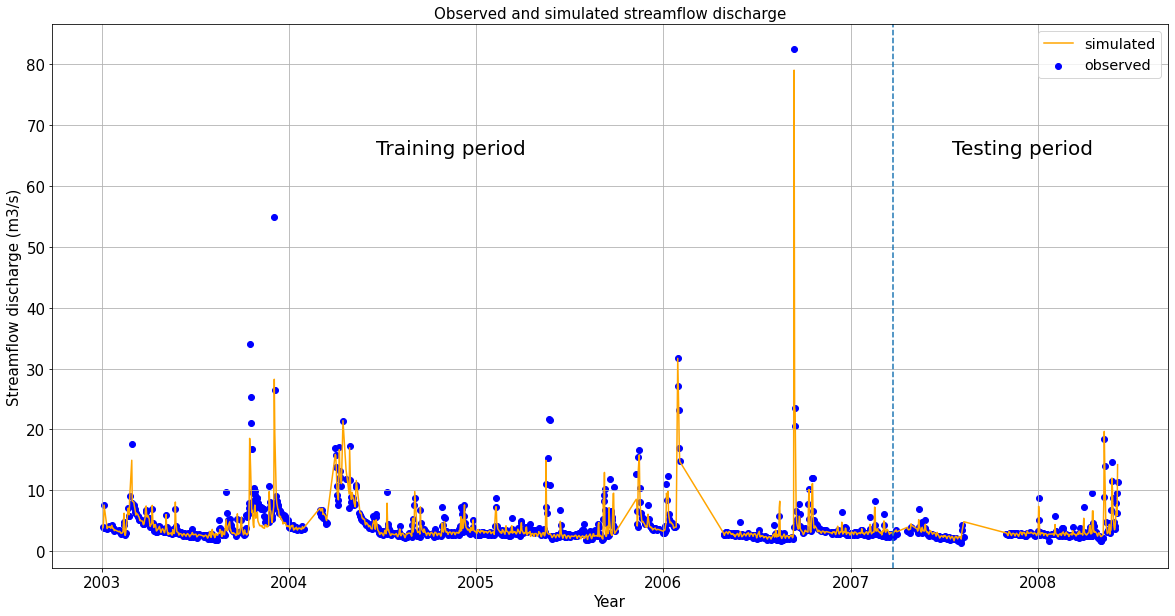

In [438]:
# Hydrograph plot for both training and test periods
plt.scatter(df.iloc[int(len(df)*0.80):].index, df.iloc[int(len(df)*0.80):].y, color ='b', label= "observed")
plt.scatter(df.iloc[:int(len(df)*0.80)].index, df.iloc[:int(len(df)*0.80)].y, color ='b')
plt.plot(df.iloc[int(len(df)*0.80):].index, test['y'], 'orange', label="simulated")
plt.plot(df.iloc[:int(len(df)*0.80)].index, y_train, 'orange')
plt.axvline(13596, 0, 80, linestyle='--')
plt.figtext(0.75, 0.7, "Testing period", fontsize = 20)
plt.figtext(0.35, 0.7, "Training period", fontsize = 20)
plt.title("Observed and simulated streamflow discharge", fontsize=15)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Streamflow discharge (m3/s)',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.legend(fontsize="x-large")
plt.show()

### RandomForest Regression

In [ ]:
param= {'n_estimators' : [300,330,350,380,400,430,450,480,500],
        'max_features' : ("auto", "sqrt", "log2"),
       },

In [ ]:
#Time counter
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
#Grid search hyperparameters tuning
model = RandomForestRegressor(random_state = 42)
grids = GridSearchCV(model,param,cv=5,n_jobs = 2, verbose = 3)

In [ ]:
from datetime import datetime

start_time = timer(None)
grids.fit(X_train, y_train)
timer(start_time)

In [ ]:
#The best RF hyperparameters
grids.best_params_

In [441]:
rf = RandomForestRegressor(n_estimators = 400, max_features= 'sqrt', random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

Training period

In [442]:
y_train = rf.predict(X_train)

In [443]:
mse =  mean_squared_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print('MSE =',mse)

MSE = 0.9574458395938861


In [444]:
mae = mean_absolute_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print("MAE =", mae)

MAE = 0.25866609534766394


In [445]:
r2 = r2_score(df.iloc[:int(len(df)*0.80)].y, y_train)
print("R2 =", r2)

R2 = 0.9454219152448018


In [446]:
ce = he.evaluator(he.nse, df.iloc[:int(len(df)*0.80)].y, y_train)
print("CE =", ce)

CE = [0.92308984]


Test period

In [447]:
y = rf.predict(X_test)

In [448]:
test['y']=y

In [449]:
mse=mean_squared_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MSE =',mse)

MSE = 0.5731532328009852


In [450]:
mae = mean_absolute_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MAE =', mae)

MAE = 0.5440356275334175


In [451]:
r2= r2_score(df.iloc[int(len(df)*0.80):].y, y)
print('R2 =', r2)

R2 = 0.8405998105337633


In [452]:
ce = he.evaluator(he.nse, df.iloc[int(len(df)*0.80):].y, test.y)
print('CE =', ce)

CE = [0.83584277]


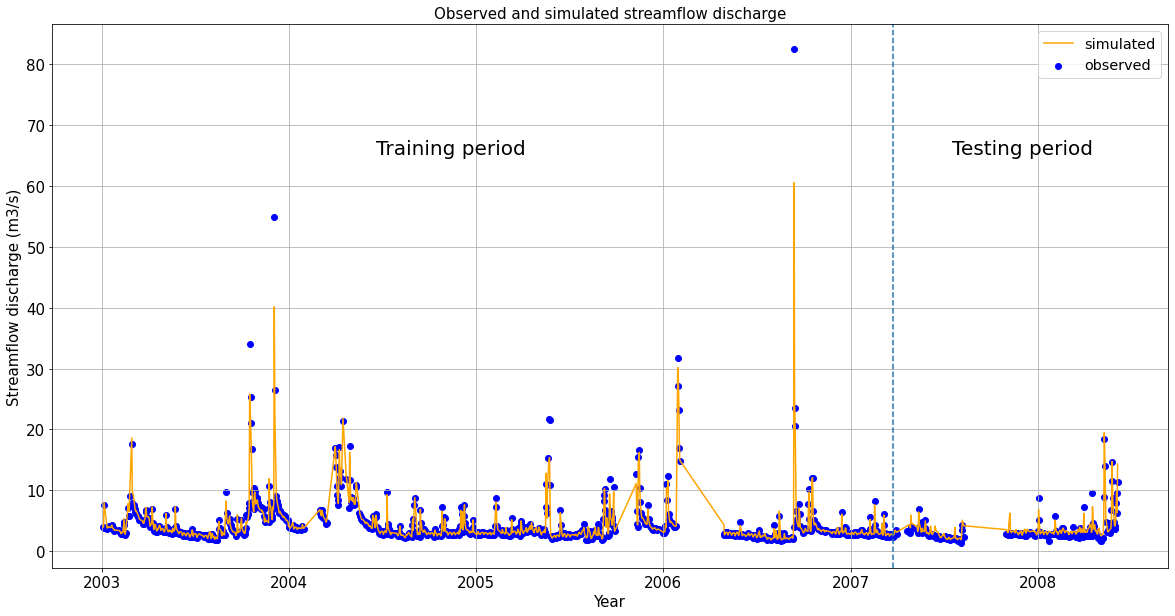

In [453]:
# Hydrograph plot for both training and test periods
plt.scatter(df.iloc[int(len(df)*0.80):].index, df.iloc[int(len(df)*0.80):].y, color ='b', label= "observed")
plt.scatter(df.iloc[:int(len(df)*0.80)].index, df.iloc[:int(len(df)*0.80)].y, color ='b')
plt.plot(df.iloc[int(len(df)*0.80):].index, test['y'], 'orange', label="simulated")
plt.plot(df.iloc[:int(len(df)*0.80)].index, y_train, 'orange')
plt.axvline(13596, 0, 80, linestyle='--')
plt.figtext(0.75, 0.7, "Testing period", fontsize = 20)
plt.figtext(0.35, 0.7, "Training period", fontsize = 20)
plt.title("Observed and simulated streamflow discharge", fontsize=15)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Streamflow discharge (m3/s)',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.legend(fontsize="x-large")
plt.show()

Now, let's model the flow discharge by considering the 2 lags historical flow the target gauging station "Santa Coloma de Gramenet"

In [254]:
df['y'] = df['Gramenet']
freq=1

Normalize_columns(df, ['Barcelona', 'Barcelona_fabra', 'Sabadell_aero', 'Garriga', 'Llica', 'el_Mogent', 'Mogoda', 'Gramenet'], inplace=True)
lag_creation(df, 1, 2, ['Barcelona'], inplace=True, freq=freq)
lag_creation(df, 1, 2, ['Barcelona_fabra'], inplace=True, freq=freq)
lag_creation(df, 1, 2, ['Sabadell_aero'], inplace=True, freq=freq)
lag_creation(df, 1, 2, ['Garriga'], inplace=True, freq=freq)
lag_creation(df, 1, 2, ['Llica'], inplace=True, freq=freq)
lag_creation(df, 1, 2, ['el_Mogent'], inplace=True, freq=freq)
lag_creation(df, 1, 2, ['Mogoda'], inplace=True, freq=freq)
lag_creation(df, 1, 3, ['Gramenet'], inplace=True, freq=freq)
date_features(df, inplace=True)
df.dropna(inplace=True)
del df['Gramenet']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [255]:
df.columns

Index(['Barcelona_fabra', 'Barcelona', 'Sabadell_aero', 'Garriga', 'Llica',
       'el_Mogent', 'Mogoda', 'y', 'lag_1_Barcelona', 'lag_1_Barcelona_fabra',
       'lag_1_Sabadell_aero', 'lag_1_Garriga', 'lag_1_Llica',
       'lag_1_el_Mogent', 'lag_1_Mogoda', 'lag_1_Gramenet', 'lag_2_Gramenet',
       'day_sin', 'day_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [256]:
df.head(1405)

,Barcelona_fabra,Barcelona,Sabadell_aero,Garriga,Llica,el_Mogent,Mogoda,y,lag_1_Barcelona,lag_1_Barcelona_fabra,...,lag_1_Garriga,lag_1_Llica,lag_1_el_Mogent,lag_1_Mogoda,lag_1_Gramenet,lag_2_Gramenet,day_sin,day_cos,month_sin,month_cos
fecha,,,,,,,,,,,,,,,,,,,,,
2003-01-05,0.189727,0.2624,0.017227,0.012201,0.259325,0.022743,0.011253,3.7913,0.0000,0.000000,...,0.012711,0.257549,0.022961,0.011485,0.032057,0.028312,-0.781831,0.623490,1.224647e-16,-1.000000e+00
2003-01-06,0.010482,0.0032,0.035275,0.032773,0.364121,0.066818,0.059861,7.6332,0.2624,0.189727,...,0.012201,0.259325,0.022743,0.011253,0.030329,0.032057,0.000000,1.000000,0.000000e+00,1.000000e+00
2003-01-11,0.000000,0.0000,0.004102,0.013630,0.261101,0.023089,0.014501,3.9437,0.0032,0.010482,...,0.032773,0.364121,0.066818,0.059861,0.077643,0.030329,-0.974928,-0.222521,5.000000e-01,-8.660254e-01
2003-01-12,0.000000,0.0000,0.000000,0.013120,0.255773,0.022730,0.012877,3.6819,0.0000,0.000000,...,0.013630,0.261101,0.023089,0.014501,0.032206,0.077643,-0.781831,0.623490,1.224647e-16,-1.000000e+00
2003-01-13,0.000000,0.0000,0.000000,0.013120,0.245115,0.028272,0.012877,3.9180,0.0000,0.000000,...,0.013120,0.255773,0.022730,0.012877,0.028982,0.032206,0.000000,1.000000,0.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-05-31,0.072327,0.2288,0.057424,0.007504,0.245115,0.011570,0.000000,3.6330,0.0000,0.000000,...,0.012711,0.259325,0.005631,0.000000,0.034591,0.042341,-0.974928,-0.222521,5.000000e-01,-8.660254e-01
2008-06-01,0.006289,0.0240,0.018868,0.007198,0.293073,0.025661,0.014501,7.9588,0.2288,0.072327,...,0.007504,0.245115,0.011570,0.000000,0.028379,0.034591,-0.781831,0.623490,1.224647e-16,-1.000000e+00
2008-06-03,0.041929,0.2736,0.127974,0.022615,0.415631,0.093608,0.027378,9.5464,0.0240,0.006289,...,0.007198,0.293073,0.025661,0.014501,0.081653,0.028379,0.781831,0.623490,5.000000e-01,8.660254e-01


We split the dataset into training and testing datasets

In [341]:
X = df.loc[:, df.columns!='y']
y = df['y']
train = df.iloc[:int(len(df)*0.80)]
test = df.iloc[int(len(df)*0.80):]

In [342]:
X_train = train.dropna().drop('y', axis=1)
y_train = train['y']

X_test = test.dropna().drop('y', axis=1)
y_test = test['y']
test = test.dropna().drop('y', axis=1)

X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

Modelling and Evaluation

### Multiple Linear Regression

In [259]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

Training period

In [272]:
y_train = reg.predict(X_train)

In [273]:
mse = mean_squared_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print('MSE =',mse)

MSE = 2.180798364153914


In [274]:
mae= mean_absolute_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print('MAE =', mae)

MAE = 0.582700189507516


In [275]:
r2 = r2_score(df.iloc[:int(len(df)*0.80)].y, y_train)
print('R2 =', r2)

R2 = 0.8757957376946269


In [276]:
ce = he.evaluator(he.nse, df.iloc[:int(len(df)*0.80)].y, y_train)
print('CE =', ce)

CE = [0.85818124]


Testing period

In [277]:
y = reg.predict(X_test)

In [279]:
test['y'] = y

In [280]:
mse = mean_squared_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MSE =', mse)

MSE = 0.6017661662045066


In [281]:
mae = mean_absolute_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MAE =', mae)

MAE = 0.38783644100062753


In [282]:
r2 = r2_score(df.iloc[int(len(df)*0.80):].y, test.y)
print('R2 =', r2)

R2 = 0.8326422404727569


In [283]:
ce = he.evaluator(he.nse, df.iloc[int(len(df)*0.80):].y, test.y)
print('CE =', ce)

CE = [0.84967997]


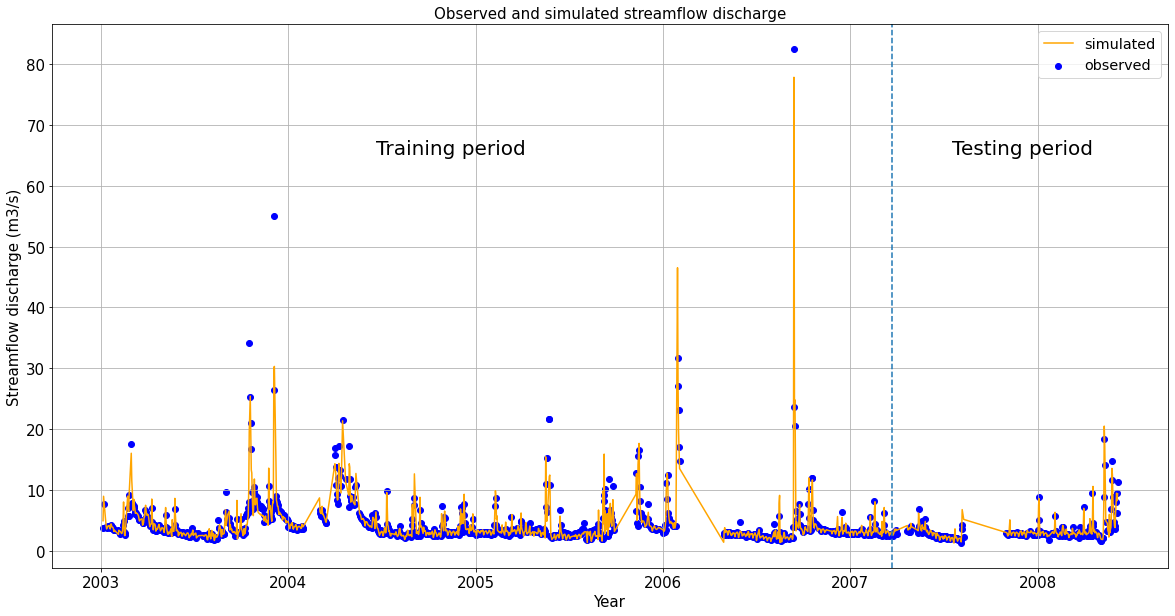

In [284]:
# Hydrograph plot for both training and test periods
plt.scatter(df.iloc[int(len(df)*0.80):].index, df.iloc[int(len(df)*0.80):].y, color ='b', label= "observed")
plt.scatter(df.iloc[:int(len(df)*0.80)].index, df.iloc[:int(len(df)*0.80)].y, color ='b')
plt.plot(df.iloc[int(len(df)*0.80):].index, test['y'], 'orange', label="simulated")
plt.plot(df.iloc[:int(len(df)*0.80)].index, y_train, 'orange')
plt.axvline(13596, 0, 80, linestyle='--')
plt.figtext(0.75, 0.7, "Testing period", fontsize = 20)
plt.figtext(0.35, 0.7, "Training period", fontsize = 20)
plt.title("Observed and simulated streamflow discharge", fontsize=15)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Streamflow discharge (m3/s)',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.legend(fontsize="x-large")
plt.show()

In [285]:
# MLR interception
Intercept=reg.intercept_
Intercept

1.1987036842317802

In [286]:
# MLR coefficients
Coefficients=reg.coef_
Coefficients

array([ 9.70564837e+00, -1.41113516e+00, -5.23703491e+00,  1.97528309e+01,
        9.36606971e+00,  3.06220187e+01,  1.29015046e+01,  4.59684755e+00,
        2.07828089e+00,  1.14507831e+01, -3.77209818e+00, -7.26481703e+00,
       -1.46609291e+01, -1.56883170e+01,  4.12135658e+01,  9.35425332e-01,
       -2.34186258e-01,  3.99417170e-02,  5.94165290e-01,  2.82438609e-01])

<BarContainer object of 20 artists>

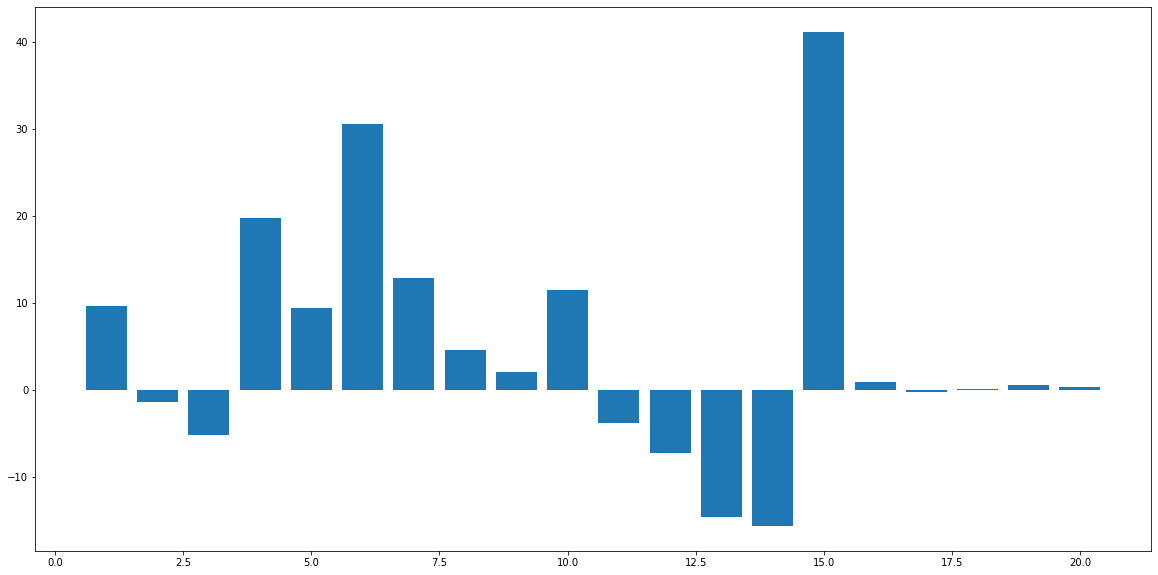

In [287]:
# MLR coefficients plot
plt.bar([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], # train.dropna().drop('y', axis=1).columns
        
        [9.70564837e+00, -1.41113516e+00, -5.23703491e+00,  1.97528309e+01,
        9.36606971e+00,  3.06220187e+01,  1.29015046e+01,  4.59684755e+00,
        2.07828089e+00,  1.14507831e+01, -3.77209818e+00, -7.26481703e+00,
       -1.46609291e+01, -1.56883170e+01,  4.12135658e+01,  9.35425332e-01,
       -2.34186258e-01,  3.99417170e-02,  5.94165290e-01,  2.82438609e-01]) # reg.coef_

### Gradient Boosting Regressor

In [ ]:
#GBR Hyperparameters
parameters = {'n_estimators'     : [400,450,500,550,600],
              'max_features'     : [0.3,0.4,0.5,0.6],
              'learning_rate'    : [0.05,0.06,0.08,0.1],
              'subsample'        : [0.2,0.3,0.4,0.5,0.6],              
              'max_depth'        : [5,7,9,11,12],
              }

In [ ]:
#Time counter
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
gbr = GradientBoostingRegressor()
#Grid search GBR hyperparameters tuning
rndm_GBR = GridSearchCV(estimator=gbr, param_grid = parameters, cv = 5, n_jobs=2, verbose=3)

In [ ]:
from datetime import datetime

start_time = timer(None)
rndm_GBR.fit(X_train, y_train)
timer(start_time)

In [ ]:
#Optimal GBR hyeprparameters
rndm_GBR.best_params_

In [329]:
#Training the GBR with the best hyperparameters
gbr = GradientBoostingRegressor(learning_rate=0.06, max_depth= 7, max_features= 0.4, n_estimators= 500, subsample= 0.2)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.06, max_depth=7, max_features=0.4,
                          n_estimators=500, subsample=0.2)

Training period

In [335]:
y_train = gbr.predict(X_train)

In [336]:
mse = mean_squared_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print('MSE =', mse)

MSE = 0.027887469505805652


In [337]:
mae= mean_absolute_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print('MAE =', mae)

MAE = 0.12850806153909217


In [338]:
r2 = r2_score(df.iloc[:int(len(df)*0.80)].y, y_train)
print('R2 =', r2)

R2 = 0.998411708925288


In [339]:
ce = he.evaluator(he.nse, df.iloc[:int(len(df)*0.80)].y, y_train)
print('CE =', ce)

CE = [0.99839982]


Testing period

In [330]:
y = gbr.predict(X_test)

In [331]:
test['y'] = y

In [332]:
mse = mean_squared_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MSE =', mse)

MSE = 0.5942303930448789


In [333]:
mae = mean_absolute_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MAE =', mae)

MAE = 0.40693450439812057


In [334]:
r2 = r2_score(df.iloc[int(len(df)*0.80):].y, test.y)
print('R2 =', r2)

R2 = 0.8347380214972292


In [ ]:
ce = he.evaluator(he.nse, df.iloc[int(len(df)*0.80):].y, test.y)
print('CE =', ce)

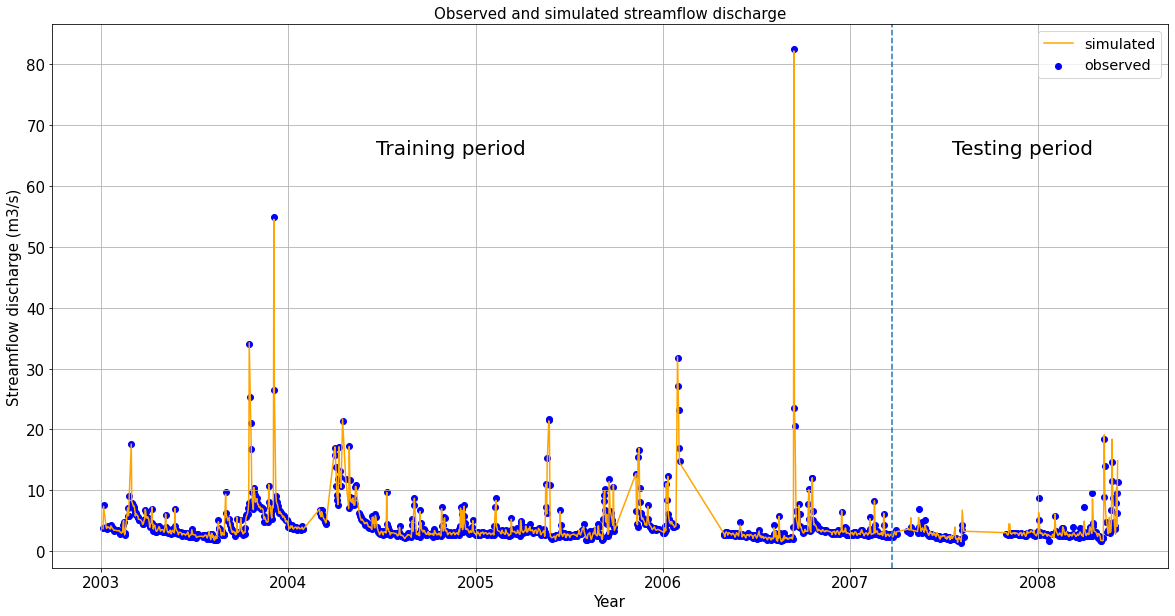

In [340]:
# Hydrograph plot for both training and test periods
plt.scatter(df.iloc[int(len(df)*0.80):].index, df.iloc[int(len(df)*0.80):].y, color ='b', label= "observed")
plt.scatter(df.iloc[:int(len(df)*0.80)].index, df.iloc[:int(len(df)*0.80)].y, color ='b')
plt.plot(df.iloc[int(len(df)*0.80):].index, test['y'], 'orange', label="simulated")
plt.plot(df.iloc[:int(len(df)*0.80)].index, y_train, 'orange')
plt.axvline(13596, 0, 80, linestyle='--')
plt.figtext(0.75, 0.7, "Testing period", fontsize = 20)
plt.figtext(0.35, 0.7, "Training period", fontsize = 20)
plt.title("Observed and simulated streamflow discharge", fontsize=15)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Streamflow discharge (m3/s)',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.legend(fontsize="x-large")
plt.show()

### Support Vector Regression

In [ ]:
#SVR hyperparameters
param={
  "C"        :  [0.1,1.0,10,100,1000],
 "epsilon"   :  [0.0001,0.001,0.01,0.1,1],
 "gamma"     :  [0.0001,0.001,0.01,0.1,1],
}

In [ ]:
#Time counter function
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
modelsvr = SVR(kernel='rbf')
#Grid search SVR hyperparameters tuning
grids = GridSearchCV(modelsvr,param,cv=5,n_jobs = 2, verbose = 3)

In [ ]:
from datetime import datetime

start_time = timer(None)
grids.fit(X_train, y_train)
timer(start_time)

In [ ]:
#The optimal SVR hyperparameters
grids.best_params_

In [290]:
#Training the SVR with the best hyperparameters
modelsvr = SVR(kernel='rbf', C=1000, epsilon=0.0001, gamma=0.01)
modelsvr.fit(X_train, y_train)

SVR(C=1000, epsilon=0.0001, gamma=0.01)

Training period

In [291]:
y_train = modelsvr.predict(X_train)

In [292]:
mse = mean_squared_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print('MSE =', mse)

MSE = 2.4438962937950706


In [293]:
mae= mean_absolute_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print('MAE =', mae)

MAE = 0.4919492481592446


In [294]:
r2 = r2_score(df.iloc[:int(len(df)*0.80)].y, y_train)
print('R2 =', r2)

R2 = 0.8608113701335164


In [295]:
ce = he.evaluator(he.nse, df.iloc[:int(len(df)*0.80)].y, y_train)
print('CE =', ce)

CE = [0.80542359]


Testing period

In [296]:
y = modelsvr.predict(X_test)

In [297]:
test['y'] = y

In [298]:
mse = mean_squared_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MSE =',mse)

MSE = 0.33456600423297034


In [299]:
mae = mean_absolute_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MAE =',mae)

MAE = 0.3071957454513668


In [300]:
r2= r2_score(df.iloc[int(len(df)*0.80):].y, y)
print('R2 =',r2)

R2 = 0.9069535310774128


In [301]:
ce = he.evaluator(he.nse, df.iloc[int(len(df)*0.80):].y, test.y)
print('CE =', ce)

CE = [0.89017079]


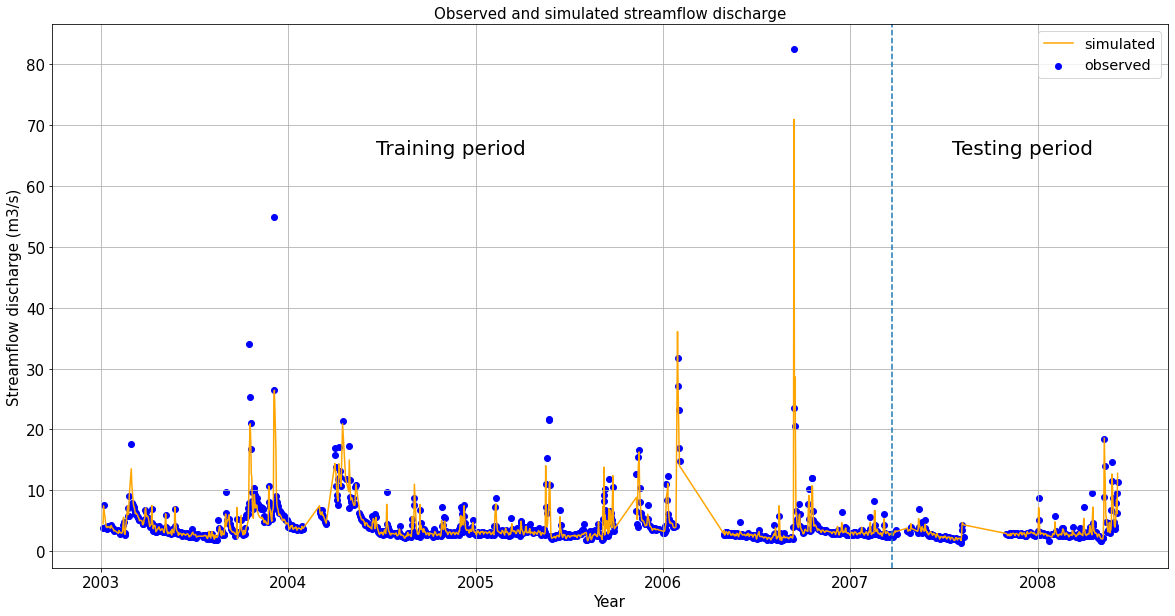

In [302]:
# Hydrograph plot for both training and test periods
plt.scatter(df.iloc[int(len(df)*0.80):].index, df.iloc[int(len(df)*0.80):].y, color ='b', label= "observed")
plt.scatter(df.iloc[:int(len(df)*0.80)].index, df.iloc[:int(len(df)*0.80)].y, color ='b')
plt.plot(df.iloc[int(len(df)*0.80):].index, test['y'], 'orange', label="simulated")
plt.plot(df.iloc[:int(len(df)*0.80)].index, y_train, 'orange')
plt.axvline(13596, 0, 80, linestyle='--')
plt.figtext(0.75, 0.7, "Testing period", fontsize = 20)
plt.figtext(0.35, 0.7, "Training period", fontsize = 20)
plt.title("Observed and simulated streamflow discharge", fontsize=15)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Streamflow discharge (m3/s)',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.legend(fontsize="x-large")
plt.show()

### Random Forest Regression

In [343]:
#RFR hyperparameters
param= {'n_estimators' : [300,330,350,380,400,430,450,480,500],
        'max_features' : ("auto", "sqrt", "log2"),
       },

In [344]:
#Time counter function
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [345]:
model = RandomForestRegressor(random_state = 42)
# Grid search RFR hyperparameters tuning
grids = GridSearchCV(model,param,cv=5,n_jobs = 2, verbose = 3)

In [346]:
from datetime import datetime

start_time = timer(None)
grids.fit(X_train, y_train)
timer(start_time)

Fitting 5 folds for each of 27 candidates, totalling 135 fits

 Time taken: 0 hours 2 minutes and 30.94 seconds.


In [347]:
# The best RFR hyperparameters
grids.best_params_

{'max_features': 'sqrt', 'n_estimators': 480}

In [348]:
rf = RandomForestRegressor(n_estimators = 480, max_features= 'sqrt', random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

Training period

In [349]:
y_train =rf.predict(X_train)

In [350]:
mse = mean_squared_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print('MSE =', mse)

MSE = 0.8551349990763788


In [351]:
mae= mean_absolute_error(df.iloc[:int(len(df)*0.80)].y, y_train)
print('MAE =', mae)

MAE = 0.20760882622508578


In [352]:
r2 = r2_score(df.iloc[:int(len(df)*0.80)].y, y_train)
print('R2 =', r2)

R2 = 0.951297005042924


In [353]:
ce = he.evaluator(he.nse, df.iloc[:int(len(df)*0.80)].y, y_train)
print('CE =', ce)

CE = [0.9321266]


Testing period

In [354]:
y = rf.predict(X_test)

In [355]:
test['y']=y

In [356]:
mse = mean_squared_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MSE =',mse)

MSE = 0.39748478377325186


In [357]:
mae = mean_absolute_error(df.iloc[int(len(df)*0.80):].y, test.y)
print('MAE =',mae)

MAE = 0.3700825530480061


In [358]:
r2 = r2_score(df.iloc[int(len(df)*0.80):].y, y)
print('R2 =', r2)

R2 = 0.8894551295928875


In [359]:
ce = he.evaluator(he.nse, df.iloc[int(len(df)*0.80):].y, test.y)
print('CE =', ce)

CE = [0.88883174]


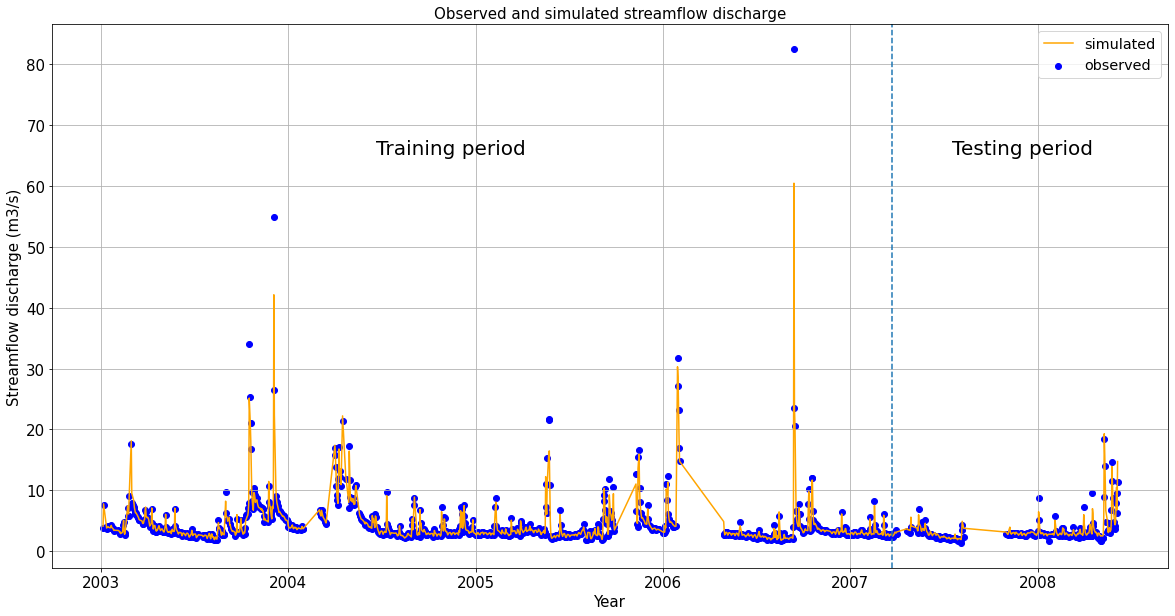

In [360]:
# Hydrograph plot for both training and test periods
plt.scatter(df.iloc[int(len(df)*0.80):].index, df.iloc[int(len(df)*0.80):].y, color ='b', label= "observed")
plt.scatter(df.iloc[:int(len(df)*0.80)].index, df.iloc[:int(len(df)*0.80)].y, color ='b')
plt.plot(df.iloc[int(len(df)*0.80):].index, test['y'], 'orange', label="simulated")
plt.plot(df.iloc[:int(len(df)*0.80)].index, y_train, 'orange')
plt.axvline(13596, 0, 80, linestyle='--')
plt.figtext(0.75, 0.7, "Testing period", fontsize = 20)
plt.figtext(0.35, 0.7, "Training period", fontsize = 20)
plt.title("Observed and simulated streamflow discharge", fontsize=15)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Streamflow discharge (m3/s)',fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
plt.legend(fontsize="x-large")
plt.show()

#### FINAL CONCLUSION

**The performance comparison of the results revealed that the SVR model outperformed the other models in predicting daily flow without and with considering the historical at the target station. It was also deduced that taking into account the previous flows in the objective gauging station clearly improves the prediction results.**